# Analysis Overview

This notebook includes the code for various static and interactive plots used to analyze the results of the study presented in 'Examining Explicit Discretization in Spectral Schemes'. The discussions of these plots are located in the paper and supplemental appendicies. Due to fact that we have chosen to inline certain variables and definitions, the nodes in this document need to be run sequentially.

## Initialization Code

In [1]:
# initialize matplotlib interactive widgets
%matplotlib widget

In [2]:
# increase default notebook width and shift tables to the left
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>table {float:left};</style>"))

In [3]:
# ---------- Imports ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from PIL import Image

from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GroupShuffleSplit,GridSearchCV
from skimage import color, feature

import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy

In [4]:
# ---------- Setup ----------
# data directory
dataDir = "./data/"

# color maps -- note: conversion from data specification to label for Default / Traditional
cmap_label = ['Traditional', 'Jet', 'Kindlmann', 'Gray']
cmap_str = ['Default', 'Jet', 'Kindlmann', 'Gray']

# additional labels
param_label = ['L*', 'C*', 'h']
indicator_label = ['Cusps (High Curvature)', 'Inflection Points']

### Data Import

In [5]:
# load all color maps, make accessible by label
cmaps = dict(zip(cmap_label,list(pd.read_csv(dataDir+'colormaps/'+v.lower()+".csv") for v in cmap_str)))

In [6]:
# import records
records = pd.read_csv(dataDir+'records/'+"categoryRecords.csv")
records2 = pd.read_csv(dataDir+'records/'+"boundaryRecords.csv")

# outliers as dictated by our analysis
outliers = ['9229247b-f93a-4bd4-a47a-08ccc1addf2c', 
            '85434358-433b-4dcf-ac84-a87418eed8ef', 
            'c47869d4-cabe-40b9-89f4-74c76451dfe5', 
            '2652ec50-3918-492f-9d65-6210c2ca3031', 
            'cd9cf3f9-29f6-40df-baca-c3e77d71f0be', 
            'cfd3daa0-df19-4714-a47b-bf8d39aa74c5']

In [7]:
survey = pd.read_csv(dataDir+'records/'+"categorySurvey.csv")
survey2 = pd.read_csv(dataDir+'records/'+"boundarySurvey.csv")

### Convenience Definitions

In [8]:
# ---------- Convenience Functions ----------
from ConvenienceClasses import SingleLinePlotHandle, Interpolated, ParamControl, QuickObj

#  generates figure that plots curves w/ indicators
def plot_curves(cmaps, order=None, indicators=None, legend=False):
    
    # if no labels provided, use keys from required dict
    cmap_labels = list(cmaps.keys())
    if order is not None:
        cmap_labels = [cmap_labels[i] for i in order]
    
    # setup figure
    fig = plt.figure(figsize=(10,3.2))
    fig.subplots_adjust(top=0.90, right=0.97, left=0.07, bottom=0.12)

    # setup gridspecs
    gs = gridspec.GridSpec(5, len(cmaps.keys()), height_ratios=[2,4,4,4,1])
    
    # convenience switches
    ylims_switch = {'L*':[0,100], 'C*':[0,140], 'h':[0,2*np.pi]}
    # colors_switch = {'L*':['#6BB1B5','#0E6089','#5E50A3'], 'C*':['#89B776','#992B65','#DB7723','#0E6089'], 'h':['#C2C673','#5E50A3','#1C9B37','#992B65']}
    colors_switch = {'L*':['#336699', '#003366'], 'C*':['#669933', '#336633'], 'h':['#339999', '#006666']}

    # for each color map
    for i in range(len(cmaps.keys())):
        
        # grab colormap
        colormap = cmaps[cmap_labels[i]]
        
        # convenience switch
        colormap_switch = {'L*': colormap.L, 'C*':colormap.C, 'h':colormap.h}

        # create image
        rgb = colormap[['r','g','b']].values
        rgb.shape = (1,rgb.shape[0],rgb.shape[1])
        rgb_image = np.repeat(rgb, 50, axis=0)
        
        # plot image
        ax = plt.subplot(gs[0,i])
        ax.imshow(rgb_image, interpolation='nearest', aspect='auto', extent=[0.0,1.0,0.0,1.0])
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(True)
        ax.tick_params(labelbottom=False)  
        ax.set_title(cmap_labels[i])

        # store axes
        ax_handles = []

        # setup plots
        #   Luminance
        ax = plt.subplot(gs[1,i])
        ax.plot(colormap.x, colormap_switch['L*'], color='#333333')
        ax.set_xlim([0,1])
        ax.set_ylim(ylims_switch['L*'])
        ax.tick_params(labelbottom=False)  
        ax_handles.append(ax)

        #   Chroma    
        ax = plt.subplot(gs[2,i])
        ax.plot(colormap.x, colormap_switch['C*'], color='#333333')
        ax.set_xlim([0,1])
        ax.set_ylim(ylims_switch['C*'])
        ax.tick_params(labelbottom=False)
        ax_handles.append(ax)

        #   Hue    
        ax = plt.subplot(gs[3,i])
        ax.plot(colormap.x, colormap_switch['h'], color='#333333')
        ax.set_xlim([0,1])
        ax.set_ylim(ylims_switch['h'])
        ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
        ax.set_yticklabels(['$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
        ax_handles.append(ax)
        
        # if indicators available
        if indicators is not None:
            # grab color map label
            c = cmap_labels[i]
            # for parameter axes
            for j in range(len(ax_handles)):
                p = param_label[j]
                ax = ax_handles[j]
                cc = colors_switch[p]
                
                # draw indicators
                for xc in indicators[c][p]['Cusps (High Curvature)']:
                    ax.axvline(x=xc, color=cc[0], linestyle='--', alpha=0.55)
                
                for xc in indicators[c][p]['Inflection Points']:
                    ax.axvline(x=xc, color=cc[1], linestyle=':', alpha=0.55)
                    
        # add labels to right hand side of plots
        if (i==0):
            ax_handles[0].set_ylabel(r'L$^{*}$', rotation='horizontal', fontsize=14, va='center', ha='right', labelpad=3)
            ax_handles[1].set_ylabel(r'C$^{*}$', rotation='horizontal', fontsize=14, va='center', ha='right', labelpad=3)
            ax_handles[2].set_ylabel('h',  rotation='horizontal', fontsize=14, va='center', ha='right', labelpad=13)
            ax_handles[2].set_xlabel('Normalized Value')
    
    if legend:
        cusp_line = Line2D([],[], color='#666666', linestyle='--', alpha=0.55, label='Cusp (High Curvature)')
        inflection_line = Line2D([],[], color='#333333', linestyle=':', alpha=0.55, label='Inflection Point')
        legend1 = plt.figlegend(handles=[cusp_line, inflection_line], loc = 'lower right', bbox_to_anchor=(0.68, 0.0), ncol=2, labelspacing=0.2)
        plt.gca().add_artist(legend1)
        
        L_line = Line2D([],[], color=colors_switch['L*'][0], alpha=0.55, label='L*')
        C_line = Line2D([],[], color=colors_switch['C*'][0], alpha=0.55, label='C*')
        h_line = Line2D([],[], color=colors_switch['h'][0], alpha=0.55, label='h')
        plt.figlegend(handles=[L_line, C_line, h_line], loc = 'lower left', bbox_to_anchor=(0.68, 0.0), ncol=3, labelspacing=0.2)
    
    return fig

#  plots an rbg image + LCh profile on the specified axes
def plotProfile(x, L, C, h, rgb, axes=[]):        
    assert (len(axes) == 4), "plotProfile() requires 4 axes"
    
    # convenience switches
    ylims_switch = {'L*':[0,100], 'C*':[0,140], 'h':[0,2*np.pi]}
    
    # rgb image     
    rgb.shape = (1,256, 3)
    rgb_image = np.repeat(rgb, 50, axis=0)
    axes[0].imshow(rgb_image, interpolation='nearest', aspect='auto', extent=[0.0,1.0,0.0,1.0])
    axes[0].get_yaxis().set_visible(False)
    axes[0].get_xaxis().set_visible(True)
    axes[0].tick_params(labelbottom=False)
    
    # luminance
    axes[1].plot(x, L, color='#333333')
    axes[1].set_xlim([0,1])
    axes[1].set_ylim(ylims_switch['L*'])
    axes[1].tick_params(labelbottom=False)  

    # chroma    
    axes[2].plot(x, C, color='#333333')
    axes[2].set_xlim([0,1])
    axes[2].set_ylim(ylims_switch['C*'])
    axes[2].tick_params(labelbottom=False)

    # hue    
    axes[3].plot(x, h, color='#333333')
    axes[3].set_xlim([0,1])
    axes[3].set_ylim(ylims_switch['h'])
    axes[3].set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    axes[3].set_yticklabels(['$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

#  indicator derivation plots
def plotParam(figure, colormap, param='L*', xs=np.linspace(0,1,10000)):
    # setup gridspecs
    gs = gridspec.GridSpec(4, 1, height_ratios=[1.5,4,4,4])
    
    # switch dicts
    colormap_switch = {'L*': colormap.L, 'C*':colormap.C, 'h':colormap.h}
    ylims_switch = {'L*':[0,100], 'C*':[0,140], 'h':[0,2*np.pi]}
    
    # generate spline
    current_param = Interpolated(colormap.x, colormap_switch[param], 0.5)
    
    # create image
    rgb = colormap[['r','g','b']].values
    rgb.shape = (1,rgb.shape[0],rgb.shape[1])
    rgb_image = np.repeat(rgb, 50, axis=0)
    
    axes = []
    # plot image
    ax = plt.subplot(gs[0,0])
    im_obj = ax.imshow(rgb_image, interpolation='nearest', aspect='auto')
    ax.get_yaxis().set_visible(False)
    ax.tick_params(labelbottom=False)
    axes.append(ax)
    
    # plot spline
    ax = plt.subplot(gs[1,0])
    l, = ax.plot(xs, current_param.spline(xs), color='C0')
    ax.set_xlim([0,1])
    ax.tick_params(labelbottom=False)
    ax.set_ylim(ylims_switch[param])
    if (param is 'h'):
        ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
        ax.set_yticklabels(['$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
    current_param.handles.append(SingleLinePlotHandle(ax, l))
    axes.append(ax)
    
    # plot |grad|
    ax = plt.subplot(gs[2,0])
    l, = ax.plot(xs, np.abs(current_param.grad(xs)), color='C0')
    ax.set_xlim([0,1])
    ax.tick_params(labelbottom=False)
    current_param.handles.append(SingleLinePlotHandle(ax, l))
    axes.append(ax)
    
    # plot |curv|
    ax = plt.subplot(gs[3,0])
    l, = ax.plot(xs, np.abs(current_param.curv(xs)), color='C0')
    ax.set_xlim([0,1])
    current_param.handles.append(SingleLinePlotHandle(ax, l))
    axes.append(ax)
    
    return (axes, current_param, im_obj)

#  pretty print for sensitivity analysis
def sigma_senstitivity(colormap, param_str, indicator_str, sigma_values=[], thresholds=[], tol=0.005):
        
    colormap_switch = {'L*': colormap.L, 'C*':colormap.C, 'h':colormap.h}
    current_param = Interpolated(colormap.x, colormap_switch[param_str], 0)

    indicator_locations = []
    for i in range(len(sigma_values)):
        current_param.sigma = sigma_values[i]
        if indicator_str == indicator_label[0]:
            _list = current_param.getHighCurv(thresholds[i])
        elif indicator_str == indicator_label[1]:
            _list = current_param.getInflectionPoints(thresholds[i])
        else:
            _list = []
        indicator_locations.append(_list)

    indicator_sets = []
    iterators = np.array([iter(l) for l in indicator_locations])
    current = np.array([next(i, np.NaN) for i in iterators])

    nan_mask = np.isnan(current)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") #ignore NaN runtime warning -- we're relying on propogating NaNs for stop condition
        while not all(nan_mask):
            mask = (current - min(current)) < tol    
            push = current.copy()
            push[~nan_mask & ~mask] = np.NaN
            indicator_sets.append(push)
            current[~nan_mask & mask] = np.array([next(i, np.NaN) for i in iterators[~nan_mask & mask]])
            nan_mask = np.isnan(current)

    df = pd.DataFrame(np.transpose(np.array(indicator_sets)))
    df.insert(0, 'sigma', sigma_values)
    df.insert(1, 'threshold', thresholds)
    
    return (df)

# getDelimeters()
#   returns a numpy array of all delimeters from record_set 
#   placed by particpants for a given dataset and colormap (cmap)
#   [optional argument two_sd drops records of outlier participants]
def getDelimeters(record_set, dataset, cmap, two_sd=True, flattened=True):
    
    # get delimeters
    gr = record_set[(record_set.cmap == cmap) & (record_set.data == dataset)]
    if (two_sd):
        delimeters = (gr[~gr['UUID'].isin(outliers)]).iloc[:,6:]
    else:
        delimeters = gr.iloc[:,6:]
    
    # flatten (preserving participant unnecessary for density estimation)
    if flattened:
        d2 = delimeters.values.flatten()
        # remove null values
        d2 = d2[~np.isnan(d2)]
        return(d2)
    else:
        #return(np.array(delimeters.values))
        return(delimeters.dropna(axis='columns', how='all'))

def getGroupedDelimeters(record_set, dataset, cmap, two_sd=True):
    
    # get delimeters
    gr = record_set[(record_set.cmap == cmap) & (record_set.data == dataset)]
    if (two_sd):
        delimeters = (gr[~gr['UUID'].isin(outliers)]) #.iloc[:,6:-1]
    else:
        delimeters = gr
    
    d2 = pd.melt(delimeters.drop(['participant','block','cmap','data','num_color_categories'], axis=1), id_vars=['UUID']).dropna(axis='rows', how='any').drop(['variable'], axis=1)
    
    return((d2.values[:,0], d2.values[:,1]))

# indicator formatter
def getFormattedPredictors(spec_tuples, indicators, est = 0.07):
    colors_switch = {'L*':['#4466CC', '#003366'], 'C*':['#228822', '#226622'], 'h':['#228888', '#006666']}
    style_switch = {'Cusps (High Curvature)':'--', 'Inflection Points': ':'}
    output = []
    for cmap_str,param_str,label in spec_tuples:
        output = output + [[[i],[est],[colors_switch[param_str][indicator_label.index(label)]],[style_switch[label]],[colors_switch[param_str][0]]] for i in indicators[cmap_str][param_str][label]]
    return output

# placement plots w/ predictors
def plot_delimeters(records, dataset, cmap, condition, axes=None, predictor_set=[[[],[],[]]], r_sorted=True, mask=None, two_sd=True, bandwidth=None, kernel='epanechnikov'):
    
    fig_h = 6.5
    fig_t = 0.91
    fig_b = 0.13
    
    if axes is None:
        fig = plt.figure(figsize=(3.5,fig_h))
        fig.subplots_adjust(top=fig_t, right=0.93, left=0.15, bottom=fig_b)
        gs = gridspec.GridSpec(2, 1, height_ratios=[4,2.5])
        ax = plt.subplot(gs[0,0])
        ax2 = plt.subplot(gs[1,0])
    else:
        ax = axes[0] # add error check for improper number of axes
        ax2 = axes[1]
    
    # -------------------- Data Processing -----------------------
    
    # Grab Delimeters
    gr = records[(records.cmap == cmap.lower()) & (records.data == dataset)]
    if (two_sd):
        delimeters = (gr[~gr['UUID'].isin(outliers)])
    else:
        delimeters = gr
            
    if r_sorted:
        # drop ignored
        delimeters = delimeters.drop(['participant','block','cmap','num_color_categories','data'], axis=1)

        # average count by mask
        if mask is None:
            # mask to displayed records            
            # gr = records[(records.cmap == cmap.lower()) & (records.data == dataset)]
            # mask to all records -- sort by average number of delimiters placed
            gr = records[(records.data == '1D') | (records.data == '2D') | (records.data == 'Complex')]
        else:
            gr = records[mask]
            
        if (two_sd):
            d2 = (gr[~gr['UUID'].isin(outliers)])
        else:
            d2 = gr
                    
        d2 = d2.drop(['participant','block','cmap','num_color_categories'], axis=1)
        d2['count'] = d2.drop(['UUID', 'data'],axis=1).count(axis=1)
        d2 = d2.loc[:,['UUID', 'count']].groupby('UUID', as_index=False).mean()

        # merge, sort, drop
        delimeters = pd.merge(delimeters, d2, on='UUID').sort_values('count').drop(['UUID', 'count'], axis=1)
    else:
        # drop ignored     
        delimeters = delimeters.iloc[:,6:]

    # ----------------------- Plot ---------------------------
    cmap_str = 'Traditional' if (cmap == 'Default') else cmap
    
    if ax is not None:
        ax.set_title(cmap_str+" - "+dataset)
        ax.set_ylabel('Participants')
        ax.set_xlim([0, 1.0])
        
        # draw delimeter placements
        R = delimeters.shape[0]
        ry = np.ones(delimeters.shape[1])
        for r in range(R):
            ax.scatter(np.clip(delimeters.values[r], 0, 1), ry*(r+1), color='black', marker="|", s=30, lw=2, zorder=3)
    
        if (two_sd): ax.set_ylim([0, 32]) #consistency hack
        ylims = ax.get_ylim()

    if ax2 is not None:
        ax2.set_ylabel('Probability Density')
        ax2.set_xlabel('Normalized Data Value')
        ax2.set_xlim([0, 1.0])
    
    
        # estimate and plot PDF
        #     prep delimeters for KDE
        groups, delimeters = getGroupedDelimeters(records, dataset, cmap.lower())
        #     instantiate KDE
        if bandwidth is None:
            #use grid search cross-validation to optimize the bandwidth
            grid = GridSearchCV(KernelDensity(kernel='epanechnikov'), {'bandwidth': np.linspace(0.01, 0.2, 50)}, cv=GroupShuffleSplit(n_splits=10, test_size=0.1, random_state=0))#random_state set for consistency across runs
            grid.fit(delimeters.reshape(-1, 1), groups=groups)  
            kde = grid.best_estimator_
        else:
            kde = KernelDensity(bandwidth=bandwidth, kernel='epanechnikov')
            kde.fit(delimeters.reshape(-1, 1))

        data2color = {'1D': '#323838', '2D': '#323838', 'Complex': '#323838'}#{'1D': '#0E6089', '2D': '#992B65', 'Complex': '#5E50A3'}

        sample_x = np.linspace(0, 1, 1000)
        ax2.fill_between(sample_x, np.exp(kde.score_samples(sample_x[:, None])), color=data2color.get(dataset), alpha=0.4)
        ax2.set_ylim([0, ax2.get_ylim()[1]])
        ylims2 = ax2.get_ylim()
    
        
    # draw indicators
    for p_set in predictor_set:
        if (len(p_set) > 0):
            for j in range(len(p_set[0])):
                # grab indicators
                p = p_set[0][j]
                bin_width = p_set[1][j]
                cc = p_set[2][j]
                line_style = p_set[3][j]
                fc = p_set[4][j]

                # draw indicators
                if ax is not None:
                    ax.axvline(x=p, color=cc, linestyle=line_style, alpha=0.65, zorder=2)
                    if bin_width is not None:
                        ax.add_patch(Rectangle((p - bin_width/2, ylims[0]), bin_width, ylims[1]-ylims[0], facecolor=fc, alpha=0.25, zorder=1))
                
                if ax2 is not None:
                    ax2.axvline(x=p, color=cc, linestyle=line_style, alpha=0.65, zorder=2)

    # ---------------------- End --------------------------
    # display
    if axes is None: return (fig)

# convert hex to RGBA
def hex2rgba(h):
    return tuple(int((h.strip('#')+'FF')[i:i+2], 16) for i in (0, 2 ,4, 6))

# getGroupedRecords()
#   returns dict of record subsets split on unique values (see <returned_value>.groups.keys()) in survey column 'split on'
def getGroupedRecords(records, survey, split_on):
    records_expanded = records.merge(survey[['UUID']+[split_on]], on='UUID')
    return records_expanded.groupby(split_on)

---
## A Priori Analysis of the Color Maps

### CIELCh Profiles for Different 'Kindlmann' Definitions

In [9]:
#load the different versions of the kindlmann color map
kstr = ['paper_figure', 'study_version', 'moreland']
kimg = list(Image.open(dataDir+'kindlmann/'+v.lower()+".png") for v in kstr) # load LUT images 
krgb = list(np.asarray(img).reshape(1,256,3).astype('float')/255 for img in kimg) # convert rgb from uint8 to float
kLCh = list(color.lab2lch(color.rgb2lab(rgb)) for rgb in krgb) # convert rgb to CIELCh

In [10]:
#create comparison figure
try:
    fig_kindlmann
except NameError:
    pass
else:
    plt.close(fig_kindlmann) # close previous figure if re-running

# define figure
fig_h = 3.2
fig_w = 7.6
fig_kindlmann = plt.figure(figsize=(fig_w,fig_h))
fig_kindlmann.subplots_adjust(top=0.93, right=0.97, left=0.10, bottom=0.12)
gs = gridspec.GridSpec(4, 3, height_ratios=[2,4,4,4])

# normalized data range
data_range = np.linspace(0.0, 1.0, 256)

j = 0 # Plot Moreland Version
axes = list(plt.subplot(gs[i,j]) for i in range(4))
plotProfile(data_range, kLCh[j][0,:,0], kLCh[j][0,:,1], kLCh[j][0,:,2], krgb[j], axes)
# add labels
axes[0].set_title('Original Figure')
axes[1].set_ylabel(r'L$^{*}$', rotation='horizontal', fontsize=14, va='center', ha='right', labelpad=3)
axes[2].set_ylabel(r'C$^{*}$', rotation='horizontal', fontsize=14, va='center', ha='right', labelpad=3)
axes[3].set_ylabel('h',  rotation='horizontal', fontsize=14, va='center', ha='right', labelpad=13)
axes[3].set_xlabel('Normalized Value')

j = 1 # Plot Study Version -- Modified Paper Figure
axes = list(plt.subplot(gs[i,j]) for i in range(4))
plotProfile(data_range, kLCh[j][0,:,0], kLCh[j][0,:,1], kLCh[j][0,:,2], krgb[j], axes)
axes[0].set_title('Modified Figure (Linear L*)')

j = 2 # Plot Original Paper Figure
axes = list(plt.subplot(gs[i,j]) for i in range(4))
plotProfile(data_range, kLCh[j][0,:,0], kLCh[j][0,:,1], kLCh[j][0,:,2], krgb[j], axes)
axes[0].set_title('Moreland Version')

fig_kindlmann.show()

FigureCanvasNbAgg()

### CIELCh Profiles for the Color Maps Studied

In [11]:
# plot curves
try:
    fig_curves
except NameError:
    pass
else:
    plt.close(fig_curves) # close previous figure if re-running

fig_curves = plot_curves(cmaps, order=[0,1,2,3], indicators=None, legend=False)
fig_curves.show()

FigureCanvasNbAgg()

### Indicator Derivation

| Color Map   | Indicator              | Parameter | $\sigma$ | $\tau$ |
|------------:|:-----------------------|:---------|:--------|:------|
| Traditional |Cusps                  | L*        | 0       | 90000 |
| Traditional |Cusps                  | C*        | 0       | 37000 |
| Traditional |Inflection Points      | L*        | 0.6     | 295   |
| Traditional |Inflection Points      | C*        | 1.0     | 135   |
| Traditional |Inflection Points      | h         | 0       | 3     |
| Jet         |Cusps                  | L*        |       0 |  60000|
| Jet         |Cusps                  | C*        |       0 |  80000|
| Jet         |Cusps                  | h         |       0 |    990|
| Jet         |Inflection Points      | L*        |     1.2 |    158|
| Jet         |Inflection Points      | C*        |     0.8 |    100|
| Jet         |Inflection Points      | h         |     1.0 |      6|
| Kindlmann   |Cusps                  | C*        |     1.3 |  18000|
| Kindlmann   |Cusps                  | h         |     1.7 |    270|
| Kindlmann   |Inflection Points      | C*        |     1.5 |    370|
| Kindlmann   |Inflection Points      | h         |     2.5 |    3.4|

In [12]:
# ------------ INDICATOR DERIVATION TOOL ------------
from matplotlib.ticker import AutoLocator, ScalarFormatter

plt.ioff() # turns interactive mode off
plt.clf()  # clears current figure

# ------------ SMOOTHING / THRESHOLDING PARAMETERS ------------

# dictionary for switching settings
# returns (sigma, gradient_threshold, curvature_threshold)
indicator_settings = { # same as table above
    'Traditional': {
        'L*': {
            'Cusps (High Curvature)': (0, None, 90000),
            'Inflection Points': (0.6, 295, None)
        },
        'C*': {
            'Cusps (High Curvature)': (0, None, 37000),
            'Inflection Points': (1.0, 135, None)
        },
        'h': {
            'Cusps (High Curvature)': (0, None, None),
            'Inflection Points': (0, 3, None)
        }
    },
    'Jet': {
        'L*': {
            'Cusps (High Curvature)': (0, None, 60000),
            'Inflection Points': (1.2, 158, None)
        },
        'C*': {
            'Cusps (High Curvature)': (0, None, 80000),
            'Inflection Points': (0.8, 100, None)
        },
        'h': {
            'Cusps (High Curvature)': (0, None, 990),
            'Inflection Points': (1.0, 6, None)
        }
    },
    'Kindlmann': {
        'L*': {
            'Cusps (High Curvature)': (0, None, None),
            'Inflection Points': (0, None, None)
        },
        'C*': {
            'Cusps (High Curvature)': (1.3, None, 18000),
            'Inflection Points': (1.5, 370, None)
        },
        'h': {
            'Cusps (High Curvature)': (1.7, None, 270),
            'Inflection Points': (2.5, 3.4, None)
        }
    },
    'Gray': {
        'L*': {
            'Cusps (High Curvature)': (0, None, None),
            'Inflection Points': (0, None, None)
        },
        'C*': {
            'Cusps (High Curvature)': (0, None, None),
            'Inflection Points': (0, None, None)
        },
        'h': {
            'Cusps (High Curvature)': (0, None, None),
            'Inflection Points': (0, None, None)
        }
    }
}

# ------------ INITIALIZE CONTROLS, PT. 1 ------------

# initialize controls
cmap_select = widgets.Select(
                                options=cmap_label,
                                value='Traditional',
                                rows=4,
                                description='Color Map:',
                                disabled=False
                             )

param_select = widgets.Select(
                                        options=param_label,
                                        value='L*',
                                        rows=3,
                                        description='Channel:',
                                        disabled=False
                             )

indicator_select = widgets.Select(
                                        options=indicator_label,
                                        value='Cusps (High Curvature)',
                                        rows=2,
                                        description='Indicators:',
                                        disabled=False
                             )

reset_button = widgets.Button(description='reset')

# ------------ SETUP FIGURE ------------

# setup figure
try:
    fig_edgePlot
except NameError:
    pass
else:
    plt.close(fig_edgePlot) # close previous figure if re-running

fig_edgePlot = plt.figure(figsize=(6.2,5))# 11,4
fig_edgePlot.subplots_adjust(top=1.0, right=0.63, left=0.22, bottom=0.10)

xs = np.linspace(0,1,10000) # values for plotting functions

# convenience switches
colors_switch = {'L*':['#336699', '#003366'], 'C*':['#669933', '#336633'], 'h':['#339999', '#006666']}
label_switch = {'L*':r'$f(x)=$L$^*$', 'C*':r'$f(x)=$C$^*$', 'h':r'$f(x)=$h'}

# plot
axes, current_param, im_obj = plotParam(fig_edgePlot, cmaps[cmap_select.value], param_select.value, xs=xs)

# labels

axes[1].set_ylabel(label_switch['L*'], rotation='horizontal', fontsize=13)
axes[2].set_ylabel(r'$|f^{\,\prime}(x)|$', rotation='horizontal', fontsize=13)
axes[3].set_ylabel(r'$|f^{\,\prime\prime}(x)|$', rotation='horizontal', fontsize=13)
axes[3].set_xlabel('Normalized Value')

labelx = -0.35
axes[1].yaxis.set_label_coords(labelx, 0.5)
axes[2].yaxis.set_label_coords(labelx, 0.5)
axes[3].yaxis.set_label_coords(labelx, 0.5)

# add legends
cusp_line = Line2D([],[], color=colors_switch['L*'][0], linestyle='--', alpha=0.55, label='Cusp (High Curvature)')
inflection_line = Line2D([],[], color=colors_switch['L*'][1], linestyle=':', alpha=0.55, label='Inflection Point')
plt.figlegend(handles=[cusp_line, inflection_line], loc = 'upper left', bbox_to_anchor=(0.63, 0.88), ncol=1, labelspacing=0.2)
# plt.gca().add_artist(legend1)
# L_line = Line2D([],[], color=colors_switch['L*'][0], alpha=0.55, label='L*')
# C_line = Line2D([],[], color=colors_switch['C*'][0], alpha=0.55, label='C*')
# h_line = Line2D([],[], color=colors_switch['h'][0], alpha=0.55, label='h')
# plt.figlegend(handles=[L_line, C_line, h_line], loc = 'upper left', bbox_to_anchor=(0.63, 0.78), ncol=1, labelspacing=0.2)

# fig_edgePlot.show() will display a static plot, for interactive see below

# ------------ INITIALIZE CONTROLS, PT. 2 ------------

current_control = ParamControl(current_param, axes[1], axes[2], axes[3])
current_control.setColors('#336699', '#003366')

# ------------ UPDATE SCHEMES ------------
    
def update(figure, xs=[], control=None, grad=False, curv=False): 
        
    if control is not None: 
        if   grad: control.update_grad()
        elif curv: control.update_curv()
        else:      control.update_full(xs)
        
        figure.canvas.draw_idle()
        figure.canvas.flush_events()
        
def override(figure, axes, colormap, param_str, controls, im_obj=None):
    
    # override data
    param_switch = {'L*': colormap.L, 'C*':colormap.C, 'h':colormap.h}
    current_param.override(colormap.x, param_switch[param_str], current_param.sigma)
    
    # override ylims and ticks
    ylims_switch = {'L*':[0,100], 'C*':[0,140], 'h':[0,2*np.pi]}
    axes[1].set_ylim(ylims_switch[param_str])
    if (param_str == 'h'):
        axes[1].set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
        axes[1].set_yticklabels(['$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
    else:
        axes[1].yaxis.set_major_locator(AutoLocator())
        axes[1].yaxis.set_major_formatter(ScalarFormatter())
    
    # override label
    axes[1].set_ylabel(label_switch[param_str], rotation='horizontal', fontsize=13)
    
    # override indicator colors
    cc = colors_switch[param_str]
    controls.setColors(cc[0], cc[1])
    
    # override legend
    cusp_line = Line2D([],[], color=cc[0], linestyle='--', alpha=0.55, label='Cusp (High Curvature)')
    inflection_line = Line2D([],[], color=cc[1], linestyle=':', alpha=0.55, label='Inflection Point')
    plt.figlegend(handles=[cusp_line, inflection_line], loc = 'upper left', bbox_to_anchor=(0.63, 0.88), ncol=1, labelspacing=0.2)
    
    # re-draw
    update(figure, xs=xs, control=controls)

def update_cmap(change, im_obj):
    
    # create new image
    colormap = cmaps[cmap_select.value]
    
    # create new image
    rgb = colormap[['r','g','b']].values
    rgb.shape = (1,rgb.shape[0],rgb.shape[1])
    rgb_image = np.repeat(rgb, 50, axis=0)
    im_obj.set_data(rgb_image)
    
    # override plots
    override(fig_edgePlot, axes, colormap, param_select.value, current_control)
    
    #reset indicators
    update_indicators(current_control)  # indicator_select.value = None

def update_param(change):
    
    # override plots
    override(fig_edgePlot, axes, cmaps[cmap_select.value], param_select.value, current_control)
    
    # reset indicators
    update_indicators(current_control)  # indicator_select.value = None

def update_indicators(controls):
    
    s, g_thresh, c_thresh = indicator_settings[cmap_select.value][param_select.value][indicator_select.value]
    
    controls.sigma_control.value = s
    controls.gradient_threshold.value = g_thresh if g_thresh is not None else controls.gradient_threshold.max
    controls.curvature_threshold.value = c_thresh if c_thresh is not None else controls.curvature_threshold.max

# ------------ LINK CONTROLS ------------

current_control.sigma_control.observe(       lambda change : update(fig_edgePlot, control=current_control, xs=xs),     names='value' )
current_control.curvature_threshold.observe( lambda change : update(fig_edgePlot, control=current_control, curv=True), names='value' )
current_control.gradient_threshold.observe(  lambda change : update(fig_edgePlot, control=current_control, grad=True), names='value' )

cmap_select.observe( lambda change : update_cmap(change, im_obj), names='value')
param_select.observe(update_param, names='value')
indicator_select.observe(lambda change : update_indicators(current_control), names='value')

reset_button.on_click(lambda b : update_indicators(current_control))

# ------------ DISPLAY ------------

# update initial controls state
update_indicators(current_control)

# display
widgets.HBox([widgets.VBox([cmap_select,param_select,indicator_select,current_control.widget,reset_button]), fig_edgePlot.canvas])

In [13]:
# Derived Indicators (formatted for subsequent analyses) 

# original
indicators_full = {
    'Traditional': {
        'L*': {
            'Cusps (High Curvature)': [0.25098,  0.74902],
            'Inflection Points': [0.214502]
        },
        'C*': {
            'Cusps (High Curvature)': [0.25098,  0.74902],
            'Inflection Points': [0.096852,  0.244349,  0.256319,  0.355024,  0.638564,  0.759411,  0.913586]
        },
        'h': {
            'Cusps (High Curvature)': [],
            'Inflection Points': [0.205089,  0.832291]
        }
    },
    'Jet': {
        'L*': {
            'Cusps (High Curvature)': [0.109804,  0.376471,  0.639216,  0.890196],
            'Inflection Points': [0.012758,  0.326049,  0.348109,  0.361094,  0.672307,  0.902486,  0.919723,  0.987242]
        },
        'C*': {
            'Cusps (High Curvature)': [0.109804,  0.376471,  0.639216,  0.890196],
            'Inflection Points': [0.007324,  0.01144,  0.012927,  0.099824,  0.102156,  0.221824,  0.369223,  0.383768,  0.419042,  0.646978,  0.647978,  0.651844,  0.816664,  0.992781]
        },
        'h': {
            'Cusps (High Curvature)': [0.341176,  0.376471,  0.639216,  0.658824],
            'Inflection Points': [0.347344,  0.652104,  0.728837]
        }
    },
    'Kindlmann': {
        'L*': {
            'Cusps (High Curvature)': [],
            'Inflection Points': []
        },
        'C*': {
            'Cusps (High Curvature)': [0.098039,  0.2,  0.298039 , 0.596078,  0.698039,  0.8,  0.811765],
            'Inflection Points': [0.11162,  0.146164,  0.309554,  0.474843,  0.80841]
        },
        'h': {
            'Cusps (High Curvature)': [0.007843,  0.094118,  0.113725,  0.2,  0.301961,  0.32549,  0.701961,  0.878431,  0.901961,  0.988235],
            'Inflection Points': [0.107047,  0.210065,  0.356393,  0.720725,  0.885858,  0.990418]
        }
    },
    'Gray': {
        'L*': {
            'Cusps (High Curvature)': [],
            'Inflection Points': []
        },
        'C*': {
            'Cusps (High Curvature)': [],
            'Inflection Points': []
        },
        'h': {
            'Cusps (High Curvature)': [],
            'Inflection Points': []
        }
    }
}

# reduced, removes numeric artifacts
indicators = deepcopy(indicators_full)
indicators['Traditional']['C*']['Inflection Points'] = [0.096852,  0.355024,  0.638564,  0.913586]
indicators['Jet']['L*']['Inflection Points'] = [0.326049,  0.348109,  0.672307,  0.919723]
indicators['Jet']['C*']['Inflection Points'] = [0.221824,  0.419042,  0.816664]
indicators['Jet']['h']['Inflection Points'] = [0.728837]
indicators['Kindlmann']['C*']['Cusps (High Curvature)'] = [0.098039,  0.2,  0.298039 , 0.596078,  0.698039,  0.8]
indicators['Kindlmann']['C*']['Inflection Points'] = [0.146164,  0.474843]
indicators['Kindlmann']['h']['Inflection Points'] = [0.356393]

## Sensitivity Analysis for $\sigma$

There are 4 nearly coincident cusp indicators across the hue and chroma profiles of the Kindlmann color map that are offset by a constant amount (0.00392157).

Comparing the corresponding values while varying sigma supports the conclusion that this difference is caused by the changes in smoothing (plus or minus floating point error).  

In [14]:
sigma_senstitivity(cmaps['Kindlmann'], 'C*', 'Cusps (High Curvature)', sigma_values=[1.3], thresholds=[18000]) # compare output columns (0, 1, 2, 4) to below

,sigma,threshold,0,1,2,3,4,5,6
0,1.3,18000,0.098039,0.2,0.298039,0.596078,0.698039,0.8,0.811765


In [15]:
sigma_senstitivity(cmaps['Kindlmann'], 'h', 'Cusps (High Curvature)', sigma_values=[1.7,1.3], thresholds=[270,270]).dropna(axis=1) # compare output columns (7, 9, 10, 17) to above

,sigma,threshold,0,7,8,9,10,11,17,18,19,27
0,1.7,270,0.007843,0.094118,0.113725,0.2,0.301961,0.32549,0.701961,0.878431,0.901961,0.988235
1,1.3,270,0.007843,0.098039,0.109804,0.2,0.298039,0.32549,0.701961,0.882353,0.901961,0.992157


---
## Results Analysis

### Initial Exploration of KDE Bandwidth

In [16]:
# ------------ KDE BAND WIDTH TOOL ------------
colors = ['#0E6089', '#992B65', '#5E50A3','#DB7723', '#1C9B37']
colors2 = ['#0E6089', '#992B65', '#DB7723','#1C9B37']

# -------------------- Plot -----------------------
inital_bandwidth = 0.035
kernel='epanechnikov'
two_sd=True

bandwidth = widgets.FloatSlider( orientation='vertical',
                                 description='$bandwidth$',
                                 value=inital_bandwidth,
                                 min=0.005,
                                 max=0.15,
                                 step=0.005,
                                 continuous_update=True )

display_1D = widgets.Checkbox(
                                value=True,
                                description='1D',
                                disabled=False
                             )

display_2D = widgets.Checkbox(
                                value=True,
                                description='2D',
                                disabled=False
                             )

display_Cx = widgets.Checkbox(
                                value=True,
                                description='Complex',
                                disabled=False
                             )

checkboxes = [display_1D, display_2D, display_Cx]


cmap_select = widgets.Select(
                                options=['Default', 'Jet', 'Kindlmann', 'Gray'],
                                value='Default',
                                description='Color Map:',
                                disabled=False
                             )

plt.ioff()

try:
    fig_KDE
except NameError:
    pass
else:
    plt.close(fig_KDE) # close previous figure if re-running

# initalize figure
fig_KDE = plt.figure(figsize=(8.0,3.5)) # 3.5:2.5 -> 1:.714
fig_KDE.subplots_adjust(top=0.90, right=0.95, left=0.05, bottom=0.10)
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0,0])
ax.set_title("Category")
ax.set_xlim([0, 1.0])
ax.grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
ax.set_axisbelow(True)

ax2 = plt.subplot(gs[0,1])
ax2.set_title("Boundary")
ax2.set_xlim([0, 1.0])
ax2.grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
ax2.set_axisbelow(True)

# instantiate KDE
kde = KernelDensity(bandwidth=bandwidth.value, kernel=kernel)
sample_x = np.linspace(0, 1, 1000)

# for each dataset
datasets = ['1D', '2D', 'Complex']
poly_collections = [[],[]]
delimeter_sets = [[],[]]
lines = [[],[]]
for i in range(len(datasets)):
    
    # -------- Category --------
    condition_idx = 0
    # grab delimeters
    delimeters = getDelimeters(records, datasets[i], cmap_select.value.lower())
    delimeter_sets[condition_idx].append(delimeters)
    # fit the KDE model
    kde.fit(delimeters[:, None])
        
    # plot
    pc = ax.fill_between(sample_x, np.exp(kde.score_samples(sample_x[:, None])), color=colors[i], alpha=0.4)
    pc.set_visible(checkboxes[i].value)
    poly_collections[condition_idx].append(pc)
    l, = ax.plot(delimeters, np.full_like(delimeters, (-0.1*(i+1))-0.01), '|', color=colors[i], markeredgewidth=1)
    lines[condition_idx].append(l)
    
    # -------- Boundary --------
    condition_idx = 1
    delimeters = getDelimeters(records2, datasets[i], cmap_select.value.lower())
    delimeter_sets[condition_idx].append(delimeters)
    # fit the KDE model
    kde.fit(delimeters[:, None])
        
    # plot
    pc = ax2.fill_between(sample_x, np.exp(kde.score_samples(sample_x[:, None])), color=colors[i], alpha=0.4)
    pc.set_visible(checkboxes[i].value)
    poly_collections[condition_idx].append(pc)
    l, = ax2.plot(delimeters, np.full_like(delimeters, (-0.1*(i+1))-0.01), '|', color=colors[i], markeredgewidth=1)
    lines[condition_idx].append(l)

# match y_lim
ylim1 = ax.get_ylim()
ylim2 = ax2.get_ylim()
ymax = max(ylim1[1],ylim2[1])
ax.set_ylim([ylim1[0], ymax])
ax2.set_ylim([ylim2[0], ymax])

def update_checkbox(change):
    # update visibility
    poly_collections[0][checkboxes.index(change.owner)].set_visible(change.new)
    poly_collections[1][checkboxes.index(change.owner)].set_visible(change.new)
    # re-draw
    fig_KDE.canvas.draw_idle()
    fig_KDE.canvas.flush_events()

def update_cmap(change):
    # update delimeters + plot
    kde = KernelDensity(bandwidth=bandwidth.value, kernel=kernel)
    for i in range(len(datasets)):
        delimeter_sets[0][i] = getDelimeters(records,  datasets[i], cmap_select.value.lower())
        kde.fit(delimeter_sets[0][i][:, None])
        poly_collections[0][i].get_paths()[0].vertices[1:len(sample_x)+1,1] = np.exp(kde.score_samples(sample_x[:, None]))
        lines[0][i].set_xdata(delimeter_sets[0][i])
        lines[0][i].set_ydata(np.full_like(delimeter_sets[0][i], (-0.1*(i+1))-0.01))
        delimeter_sets[1][i] = getDelimeters(records2, datasets[i], cmap_select.value.lower())
        kde.fit(delimeter_sets[1][i][:, None])
        poly_collections[1][i].get_paths()[0].vertices[1:len(sample_x)+1,1] = np.exp(kde.score_samples(sample_x[:, None]))
        lines[1][i].set_xdata(delimeter_sets[1][i])
        lines[1][i].set_ydata(np.full_like(delimeter_sets[1][i], (-0.1*(i+1))-0.01))
    # re-draw
    fig_KDE.canvas.draw_idle()
    fig_KDE.canvas.flush_events()

def update_bandwidth(change):
    # update kde instantiation
    kde = KernelDensity(bandwidth=bandwidth.value, kernel=kernel)
    # update plot
    for i in range(len(datasets)):
        kde.fit(delimeter_sets[0][i][:, None])
        poly_collections[0][i].get_paths()[0].vertices[1:len(sample_x)+1,1] = np.exp(kde.score_samples(sample_x[:, None]))
        kde.fit(delimeter_sets[1][i][:, None])
        poly_collections[1][i].get_paths()[0].vertices[1:len(sample_x)+1,1] = np.exp(kde.score_samples(sample_x[:, None]))
    # re-draw
    fig_KDE.canvas.draw_idle()
    fig_KDE.canvas.flush_events()

bandwidth.observe(update_bandwidth, names='value')
display_1D.observe(update_checkbox, names='value')
display_2D.observe(update_checkbox, names='value')
display_Cx.observe(update_checkbox, names='value')
cmap_select.observe(update_cmap, names='value')

# fig.show()
widgets.HBox([widgets.VBox([cmap_select, display_1D, display_2D, display_Cx]), bandwidth, fig_KDE.canvas])

### Data Driven KDE Bandwidth
n.b., may take 30s to return due to cross validation code

In [17]:
constant_bandwidth = 0.07
kernel='epanechnikov' #epanechnikov
two_sd=True

condition = ['category', 'boundary']
colormaps = ['Default', 'Jet', 'Kindlmann', 'Gray']
optimize = True

colors = ['#0E6089', '#992B65', '#5E50A3','#DB7723', '#1C9B37']
colors2 = ['#0E6089', '#992B65', '#DB7723','#1C9B37']

try:
    fig_Trends
except NameError:
    pass
else:
    plt.close(fig_Trends) # close previous figure if re-running

# initalize figure
fig_Trends = plt.figure(figsize=(7.0,9)) # 3.5:2.5 -> 1:.714
fig_Trends.subplots_adjust(top=0.95, right=0.95, left=0.1, bottom=0.09, wspace = 0.1, hspace = 0.2)
gs = gridspec.GridSpec(len(colormaps), 2)

# setup samples for KDE plot
sample_x = np.linspace(0, 1, 1000)

if optimize:
    #use grid search cross-validation to optimize the bandwidth
    grid = GridSearchCV(KernelDensity(kernel='epanechnikov'), {'bandwidth': np.linspace(0.01, 0.2, 50)}, cv=GroupShuffleSplit(n_splits=10, test_size=0.1, random_state=0))#random_state set for consistency across runs
else:
    # instantiate KDE w/ constant bandwidth
    kde = KernelDensity(bandwidth=constant_bandwidth, kernel=kernel)

# store handles
ax_handles = []
bandwidth_records = []

# for each color map
for j in range(len(colormaps)):
    
    isLast = (j==len(colormaps)-1) 
    
    ax = plt.subplot(gs[j,0])
    ax.set_title(colormaps[j]+" - Category")
    ax.set_xlim([0, 1.0])
    ax.grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
    ax.set_axisbelow(True)
    ax.tick_params(labelbottom=isLast)
    ax.set_ylabel('Probability Density')

    ax2 = plt.subplot(gs[j,1])
    ax2.set_title(colormaps[j]+" - Boundary")
    ax2.set_xlim([0, 1.0])
    ax2.grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
    ax2.set_axisbelow(True)
    ax2.tick_params(labelbottom=isLast)
    ax2.tick_params(labelleft=False)
    
    ax_handles.append(ax)
    ax_handles.append(ax2)
    
    # label last    
    if isLast:
        ax.set_xlabel('Normalized Value')
        ax2.set_xlabel('Normalized Value')
    
    # for each dataset
    datasets = ['1D', '2D', 'Complex']
    for i in range(len(datasets)):

        # -------- Category --------
        # grab delimeters
        groups, delimeters = getGroupedDelimeters(records, datasets[i], colormaps[j].lower())

        if optimize:
            # use best estimate for KDE
            grid.fit(delimeters.reshape(-1, 1), groups=groups)  
            kde = grid.best_estimator_
        else:
            # fit the KDE model
            kde.fit(delimeters[:, None])
        
        # plot
        pc = ax.fill_between(sample_x, np.exp(kde.score_samples(sample_x[:, None])), color=colors[i], alpha=0.35)
        
        bandwidth_records.append([datasets[i], colormaps[j], condition[0], kde.bandwidth])
        
        # -------- Boundary --------
        # grab delimeters
        groups, delimeters = getGroupedDelimeters(records2, datasets[i], colormaps[j].lower())

        if optimize:
            # use best estimate for KDE
            grid.fit(delimeters.reshape(-1, 1), groups=groups)
            kde = grid.best_estimator_
        else:
            # fit the KDE model
            kde.fit(delimeters[:, None])

        # plot
        pc = ax2.fill_between(sample_x, np.exp(kde.score_samples(sample_x[:, None])), color=colors[i], alpha=0.35)
        
        bandwidth_records.append([datasets[i], colormaps[j], condition[1], kde.bandwidth])

# match ylims
ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
ymax = max(list(map(lambda ylim: ylim[1], ylims)))
ymin = 0 # hard code minimum
for ax in ax_handles:
    ax.set_ylim([ymin,ymax])

# save ylims for later plots
consistent_ylims = [ymin,ymax]

# add legend
plt.gca().add_artist(plt.figlegend(handles=list(map(lambda i: Rectangle((0, 0), 1, 1, fc=colors[i], alpha=0.35, edgecolor=colors[i]), [0,1,2])), labels=datasets, loc = 'lower center', ncol=3, labelspacing=0.2))

fig_Trends.show()
# fig_out.savefig("KDE-trends.pdf", bbox_inches='tight')

FigureCanvasNbAgg()

## Grayscale

### 1D Artifacts

In [18]:
# grab csv
colormap = cmaps['Gray']

# grab actual image LUT used in experiment
img = Image.open(dataDir+'gray/'+'gray_map.png')
pixels = np.array(img)

# verify equivalence
r_rgb = pixels[:,:,0].flatten()
r_csv = np.uint8(np.round(colormap['r']*255)) # cast color map from float to uint8 (24bit RGB)
print("Verify same:", (np.sum(r_rgb-r_csv) == 0))
# pd.DataFrame(np.column_stack((r_rgb,r_csv))) # uncomment to view

Verify same: True


In [19]:
# histogram of color map values
try:
    fig_grayHist
except NameError:
    pass
else:
    plt.close(fig_grayHist) # close previous figure if re-running

fig_grayHist = plt.figure(figsize=(5.0,3.0))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])

# artifact locations seem to match what can be observed in the stimui (times a scaling factor)
hist_output = ax.hist(r_csv.flatten(), bins=256)
fig_grayHist.show()

FigureCanvasNbAgg()

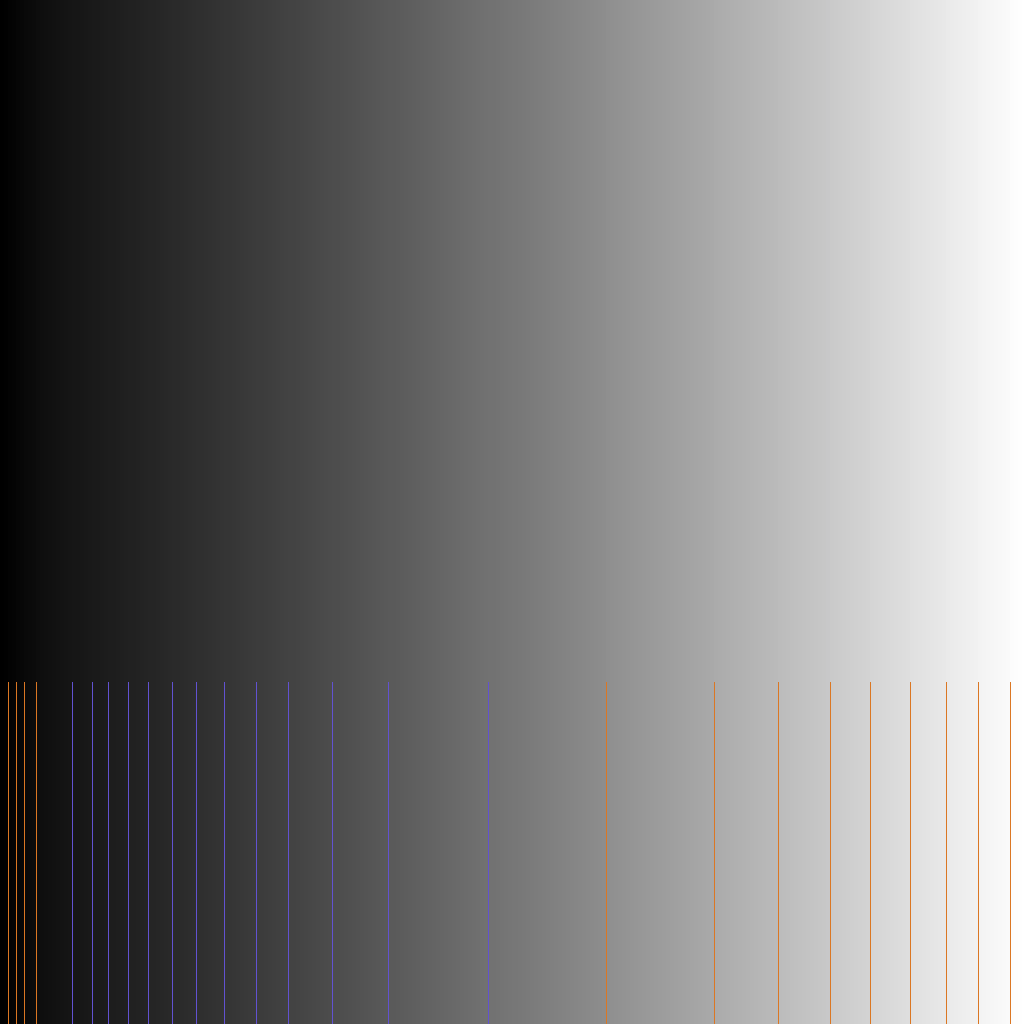

In [20]:
# plot missing and doubled values on stimuli
missing = np.arange(256)[(hist_output[0]<1)]
doubled = np.arange(256)[(hist_output[0]>1)]

# grab scaled version of image
img = Image.open(dataDir+'gray/'+'Gray1D.png')
pixels = np.array(img)
highlight = np.copy(pixels)

# get parameters for modification
scale = int(pixels.shape[0]/256)
lower = int(2*pixels.shape[0]/3)
full = pixels.shape[0]

# mask for first location after missing in colormap
mask = np.isin(pixels[0,:,0], missing+1)
prev = np.pad(mask[0:-1], (1,0), 'constant')
mask = mask & np.logical_not(prev)

# mask for first location of doubled value in colormap
mask2 = np.isin(pixels[0,:,0], doubled)
prev = np.pad(mask2[0:-1], (1,0), 'constant')
mask2 = mask2 & np.logical_not(prev)

# draw red lines on lower part of image for missing locations
highlight[lower:full, mask, :] = hex2rgba('#DB7723')

# draw blue lines on on lower part of image for doubled locations
highlight[lower:full, mask2, :] = hex2rgba('#6252D1')#5E50A3

# display
artifacts = Image.fromarray(highlight, "RGBA")
artifacts
# artifacts.save('output/artifacts.png')

### Complex Data Features

In [21]:
# load complex data
elevation = Image.open(dataDir+'gray/'+'elevation.png')
# pixels = np.array(elevation)

In [22]:
plt.ioff()

try:
    figComplexEdge
except NameError:   
    figComplexEdge = QuickObj( fig = plt.figure(figsize=(10,4)),
                     gs = gridspec.GridSpec(1, 2, width_ratios=[2,3]),
                     src = np.array(elevation).astype(float)/255,
                     handles = [])
    plt.figure(figComplexEdge.fig.number)# ensure current figure
    # create necessary handles
    figComplexEdge.handles.append(plt.subplot(figComplexEdge.gs[0,0]).imshow(figComplexEdge.src)) #cmap=plt.cm.gray
    figComplexEdge.handles.append(plt.subplot(figComplexEdge.gs[0,1]))
else:
    plt.figure(figComplexEdge.fig.number) # ensure current figure
    figComplexEdge.src = np.array(elevation).astype(float)/255 #reset data

# define update scheme 
def figComplexEdge_update(f, sigma, low, high):
    edges = feature.canny(f.src[:,:,0], sigma=sigma, low_threshold=low, high_threshold=high, use_quantiles=True)
    edge_mask = np.where(edges > 0)
    values = f.src[edge_mask][:,0].flatten()
    # update image     
    display = f.src.copy()
    display[edge_mask]= np.array([1, 0, 0, 1])#1
    f.handles[0].set_data(display)
    # recompute histogram
    f.handles[1].clear()
    f.handles[1].hist(values, bins=100, range=[0,1])
    f.handles[1].set_xlim([0, 1.0])
    # redraw
    f.fig.canvas.draw_idle()
    f.fig.canvas.flush_events()
    
# intialize controls
figComplexEdge_sigma = widgets.FloatSlider( orientation='vertical',
                                  description='$sigma$',
                                  value=1.7,
                                  min=0,
                                  max=5.0,
                                  step=0.05,
                                  continuous_update=False)

figComplexEdge_low = widgets.FloatSlider(   orientation='vertical',
                                  description='$low$',
                                  value=0.07,
                                  min=0,
                                  max=1,
                                  step=0.005,
                                  continuous_update=False)

figComplexEdge_high = widgets.FloatSlider(  orientation='vertical',
                                  description='$high$',
                                  value=0.9,
                                  min=0,
                                  max=1,
                                  step=0.005,
                                  continuous_update=False)


# inital update based on initialized control
figComplexEdge_update(figComplexEdge, figComplexEdge_sigma.value, figComplexEdge_low.value, figComplexEdge_high.value)

# watch and update on change
figComplexEdge_sigma.observe(lambda change: figComplexEdge_update(figComplexEdge, change['new'], figComplexEdge_low.value, figComplexEdge_high.value), "value")
figComplexEdge_low.observe(lambda change: figComplexEdge_update(figComplexEdge, figComplexEdge_sigma.value, change['new'], figComplexEdge_high.value), "value")
figComplexEdge_high.observe(lambda change: figComplexEdge_update(figComplexEdge, figComplexEdge_sigma.value, figComplexEdge_low.value, change['new']), "value")

# display
widgets.HBox([figComplexEdge_sigma, figComplexEdge_low, figComplexEdge_high, figComplexEdge.fig.canvas])

n.b., the next plot relies on the interactive settings of the above plot

In [24]:
from ConvenienceClasses import Interpolated

try:
    figComplexFeatures
except NameError:
    pass
else:
    plt.close(figComplexFeatures) # close previous figure if re-running

# Use KDE to find peaks
edges = feature.canny(figComplexEdge.src[:,:,0], sigma=figComplexEdge_sigma.value, low_threshold=figComplexEdge_low.value, high_threshold=figComplexEdge_high.value, use_quantiles=True)
edge_mask = np.where(edges > 0)
values = figComplexEdge.src[edge_mask][:,0].flatten()

from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.05, kernel='epanechnikov')
kde.fit(values[:, None])

# score_samples returns the log of the probability density
sample_x = np.linspace(0, 1, 1000)
logprob = kde.score_samples(sample_x[:, None])
prob = np.exp(logprob)

# use interpolating polynomial to find maxima
prob_interp = Interpolated(sample_x, prob, 1.0)
roots = prob_interp.grad.roots(discontinuity=True)
roots = roots[~np.isnan(roots)] # ignore nans
roots = roots[prob_interp.spline(roots) > 0.0005] # ignore zeros in plot
maxima = roots[prob_interp.curv(roots) < 0] # ignore zeros in plot

# threshold maxima
threshold = 0.4
maxima = maxima[prob_interp.spline(maxima) > threshold]

# Create figure
figComplexFeatures = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(1, 2, width_ratios=[3,2])
ax = plt.subplot(gs[0,0])

# KDE Plot
ax.grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
ax.set_axisbelow(True)
ax.set_xlim([0, 1.0])

ax.fill_between(sample_x, prob, alpha=0.5)
ax.plot(sample_x, prob_interp.spline(sample_x), alpha=0.3, linestyle='-', color='black')
ax.fill_between(sample_x, np.ones_like(sample_x)*threshold, alpha=0.2, color='black')
for r in maxima:
    ax.axvline(x=r, color='red', linestyle='--', alpha=0.4)

ylim1 = ax.get_ylim()
ax.set_ylim([0, ylim1[1]])

# Isocontours
ax = plt.subplot(gs[0,1])
display = np.array(elevation).astype(float)/255
ax.imshow(display)
ax.contour(display[:,:,0], levels=maxima, colors='red', linewidths=0.5)

figComplexFeatures.show()

FigureCanvasNbAgg()

### Grayscale Results

To ensure that matplotlib does not keep too many figures open the following plots close the preceeding figure before creating a new one.

In [25]:
# create indicator sets for artifacts and data features
gray_artifacts = [[[float(i)/255],[None],['#DB7723'],[':'],[None]] for i in missing] + [[[float(i+1)/255],[None],['#5E50A3'],[':'],[None]] for i in doubled]
complex_features = [[[float(i)],[None],['#992B65'],['--'],[None]] for i in maxima] #np.array([0.25171128, 0.49614456, 0.60851968, 0.85279339])

In [26]:
try:
    fig_Gray
except NameError:
    pass
else:
    plt.close(fig_Gray) # close previous figure if re-running

# hide

fig_h = 6.5
fig_t = 0.91
fig_b = 0.13
cmap = 'Gray'
predictor_set = None
ylim_overwite = [0, 3.5]
r_sorted = True
bandwidth = 0.07 # 0.07

fig_Gray = plt.figure(figsize=(10.5,fig_h))
fig_Gray.subplots_adjust(top=fig_t, right=0.93, left=0.15, bottom=fig_b)
fig_Gray.suptitle("Boundary Instruction Responses")
gs = gridspec.GridSpec(2, 3, height_ratios=[4,2.5])
ax_handles = []

axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records2, "1D",     cmap, "Boundary", axes=axes, predictor_set=gray_artifacts, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records2, "1D",     cmap, "Boundary", axes=axes, predictor_set=gray_artifacts, bandwidth=None, r_sorted=r_sorted, two_sd=True)
ax_handles.append(axes[1])

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records2, "2D",     cmap, "Boundary", axes=axes, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records2, "2D",     cmap, "Boundary", axes=axes, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records2, "Complex",     cmap, "Boundary", axes=axes, predictor_set=complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records2, "Complex",     cmap, "Boundary", axes=axes, predictor_set=complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])

# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']

alt_handles = [Line2D([0, 0], [1, 1], color='#DB7723', linestyle=':'), Line2D([0, 0], [1, 1], color='#5E50A3', linestyle=':')]
alt_str = ['Misssing Value', 'Doubled Value']

legend_ax = ax_handles[0]
legend_ax.add_artist(plt.figlegend(handles=additional_handles, labels=additional_str, loc = 'lower left', bbox_to_anchor=(0.66, 0), ncol=1, labelspacing=0))
legend_ax.add_artist(plt.figlegend(handles=alt_handles, labels=alt_str, loc = 'lower left', bbox_to_anchor=(0.35, 0), ncol=2, labelspacing=0.2))
    
fig_Gray.show()

FigureCanvasNbAgg()

In [27]:
try:
    fig_Gray
except NameError:
    pass
else:
    plt.close(fig_Gray) # close previous figure if re-running

# hide

fig_h = 6.5
fig_t = 0.91
fig_b = 0.13
cmap = 'Gray'
predictor_set = None
ylim_overwite = [0, 3.5]
r_sorted = True
bandwidth = 0.07 # 0.07

fig_Gray = plt.figure(figsize=(10.5,fig_h))
fig_Gray.subplots_adjust(top=fig_t, right=0.93, left=0.15, bottom=fig_b)
fig_Gray.suptitle("Category Instruction Responses")
gs = gridspec.GridSpec(2, 3, height_ratios=[4,2.5])
ax_handles = []

axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records, "1D",     cmap, "Category", axes=axes, predictor_set=gray_artifacts, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records, "1D",     cmap, "Category", axes=axes, predictor_set=gray_artifacts, bandwidth=None, r_sorted=r_sorted, two_sd=True)
ax_handles.append(axes[1])

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records, "2D",     cmap, "Category", axes=axes, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records, "2D",     cmap, "Category", axes=axes, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records, "Complex",     cmap, "Category", axes=axes, predictor_set=complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records, "Complex",     cmap, "Category", axes=axes, predictor_set=complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])

# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']

alt_handles = [Line2D([0, 0], [1, 1], color='#DB7723', linestyle=':'), Line2D([0, 0], [1, 1], color='#5E50A3', linestyle=':')]
alt_str = ['Misssing Value', 'Doubled Value']

legend_ax = ax_handles[0]
legend_ax.add_artist(plt.figlegend(handles=additional_handles, labels=additional_str, loc = 'lower left', bbox_to_anchor=(0.66, 0), ncol=1, labelspacing=0))
legend_ax.add_artist(plt.figlegend(handles=alt_handles, labels=alt_str, loc = 'lower left', bbox_to_anchor=(0.35, 0), ncol=2, labelspacing=0.2))

fig_Gray.show()

FigureCanvasNbAgg()

---

## Rainbow Results

To ensure that matplotlib does not keep too many figures open the following plots close the preceeding figure before creating a new one.

### H2 Plots

#### 1D Boundary 

In [ ]:
try:
    fig_H2
except NameError:
    pass
else:
    plt.close(fig_H2) # close previous figure if re-running

fig_h = 10.5
fig_t = 0.91
fig_b = 0.13
r_sorted = True

fig_H2 = plt.figure(figsize=(12,fig_h))
fig_H2.subplots_adjust(top=fig_t, right=0.95, left=0.05, bottom=fig_b)
fig_H2.suptitle("Boundary Instruction Responses")
gs = gridspec.GridSpec(3, 4, height_ratios=[4,2.5,4])
gs.update(hspace = 0.15, wspace=0.2)
ax_handles = []

specCurv = []
specInf = []

# specCurv = [('Traditional','L*','Cusps (High Curvature)'),
#             ('Traditional','C*','Cusps (High Curvature)')
#            ]

# specInf =  [('Traditional','L*','Inflection Points'),
#             ('Traditional','C*','Inflection Points'),
#             ('Traditional','h','Inflection Points')
#            ]

dataset = "1D"

axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records2, dataset,     'Default', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records2, dataset,     'Default', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,0]), None]
plot_delimeters(records2, dataset,     'Default', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels
   
specCurv = [('Jet','L*','Cusps (High Curvature)'),
            ('Jet','C*','Cusps (High Curvature)'),
            ('Jet','h','Cusps (High Curvature)'),
           ]

specInf =  [('Jet','L*','Inflection Points'),
            ('Jet','C*','Inflection Points'),
            ('Jet','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records2, dataset,     'Jet', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records2, dataset,     'Jet', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,1]), None]
plot_delimeters(records2, dataset,     'Jet', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

specCurv = [('Kindlmann','C*','Cusps (High Curvature)'),
            ('Kindlmann','h','Cusps (High Curvature)'),
           ]

specInf =  [('Kindlmann','C*','Inflection Points'),
            ('Kindlmann','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records2, dataset,     'Kindlmann', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records2, dataset,     'Kindlmann', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,2]), None]
plot_delimeters(records2, dataset,     'Kindlmann', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

# use grayscale artifacts  
axes = [plt.subplot(gs[0,3]), plt.subplot(gs[1,3])]
plot_delimeters(records2, dataset,     'Gray', "Boundary", axes=axes, predictor_set=gray_artifacts, bandwidth=None, r_sorted=r_sorted, two_sd=True) #+complex_features
axes[0].tick_params(labelbottom=False) 
for ax in axes: ax.set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])

# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)


channels_str = ['L*','C*','h'] 
colors_switch = {'L*':['#4466CC', '#003366'], 'C*':['#228822', '#226622'], 'h':['#228888', '#006666']}
channels_handles = list(map(lambda i: Rectangle((0, 0), 1, 1, fc=colors_switch[i][0], alpha=0.35), channels_str))

indicator_str = ['Cusps (High Curvature)', 'Inflection Points']
linestyles = ['--',':']
linestyles_handles = list(map(lambda i: Line2D([0, 0], [1, 1], color='gray', linestyle=linestyles[i]), [0,1]))

additional_handles = [Line2D([0, 0], [1, 1], color='#DB7723', linestyle=':'), Line2D([0, 0], [1, 1], color='#5E50A3', linestyle=':')]
additional_str = ['misssing value', 'doubled value']


legend_ax = ax_handles[3]
legend_ax.add_artist(legend_ax.legend(handles=channels_handles, labels=channels_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.3), ncol=3, labelspacing=0))
legend_ax.add_artist(legend_ax.legend(handles=linestyles_handles, labels=indicator_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.5), ncol=1, labelspacing=0.2))
legend_ax.add_artist(legend_ax.legend(handles=additional_handles, labels=additional_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.9), ncol=1, labelspacing=0))
    
fig_H2.show()

#### 1D Category 

In [29]:
try:
    fig_H2
except NameError:
    pass
else:
    plt.close(fig_H2) # close previous figure if re-running

fig_h = 10.5
fig_t = 0.91
fig_b = 0.13
r_sorted = True

fig_H2 = plt.figure(figsize=(12,fig_h))
fig_H2.subplots_adjust(top=fig_t, right=0.95, left=0.05, bottom=fig_b)
fig_H2.suptitle("Category Instruction Responses")
gs = gridspec.GridSpec(3, 4, height_ratios=[4,2.5,4])
gs.update(hspace = 0.15, wspace=0.2)
ax_handles = []

specCurv = [('Traditional','L*','Cusps (High Curvature)'),
            ('Traditional','C*','Cusps (High Curvature)')
           ]

specInf =  [('Traditional','L*','Inflection Points'),
            ('Traditional','C*','Inflection Points'),
            ('Traditional','h','Inflection Points')
           ]

dataset = "1D"

axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records, dataset,     'Default', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records, dataset,     'Default', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,0]), None]
plot_delimeters(records, dataset,     'Default', "Category", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels
   
specCurv = [('Jet','L*','Cusps (High Curvature)'),
            ('Jet','C*','Cusps (High Curvature)'),
            ('Jet','h','Cusps (High Curvature)'),
           ]

specInf =  [('Jet','L*','Inflection Points'),
            ('Jet','C*','Inflection Points'),
            ('Jet','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records, dataset,     'Jet', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records, dataset,     'Jet', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,1]), None]
plot_delimeters(records, dataset,     'Jet', "Category", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

specCurv = [('Kindlmann','C*','Cusps (High Curvature)'),
            ('Kindlmann','h','Cusps (High Curvature)'),
           ]

specInf =  [('Kindlmann','C*','Inflection Points'),
            ('Kindlmann','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records, dataset,     'Kindlmann', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records, dataset,     'Kindlmann', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,2]), None]
plot_delimeters(records, dataset,     'Kindlmann', "Category", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

# use grayscale artifacts  
axes = [plt.subplot(gs[0,3]), plt.subplot(gs[1,3])]
plot_delimeters(records, dataset,     'Gray', "Category", axes=axes, predictor_set=gray_artifacts, bandwidth=None, r_sorted=r_sorted, two_sd=True) #+complex_features
axes[0].tick_params(labelbottom=False) 
for ax in axes: ax.set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])

# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)


channels_str = ['L*','C*','h'] 
colors_switch = {'L*':['#4466CC', '#003366'], 'C*':['#228822', '#226622'], 'h':['#228888', '#006666']}
channels_handles = list(map(lambda i: Rectangle((0, 0), 1, 1, fc=colors_switch[i][0], alpha=0.35), channels_str))

indicator_str = ['Cusps (High Curvature)', 'Inflection Points']
linestyles = ['--',':']
linestyles_handles = list(map(lambda i: Line2D([0, 0], [1, 1], color='gray', linestyle=linestyles[i]), [0,1]))

additional_handles = [Line2D([0, 0], [1, 1], color='#DB7723', linestyle=':'), Line2D([0, 0], [1, 1], color='#5E50A3', linestyle=':')]
additional_str = ['misssing value', 'doubled value']


legend_ax = ax_handles[3]
legend_ax.add_artist(legend_ax.legend(handles=channels_handles, labels=channels_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.3), ncol=3, labelspacing=0))
legend_ax.add_artist(legend_ax.legend(handles=linestyles_handles, labels=indicator_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.5), ncol=1, labelspacing=0.2))
legend_ax.add_artist(legend_ax.legend(handles=additional_handles, labels=additional_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.9), ncol=1, labelspacing=0))
    
fig_H2.show()

FigureCanvasNbAgg()

#### 2D Boundary 

In [ ]:
try:
    fig_H2
except NameError:
    pass
else:
    plt.close(fig_H2) # close previous figure if re-running

fig_h = 10.5
fig_t = 0.91
fig_b = 0.13
r_sorted = True

fig_H2 = plt.figure(figsize=(12,fig_h))
fig_H2.subplots_adjust(top=fig_t, right=0.95, left=0.05, bottom=fig_b)
fig_H2.suptitle("Boundary Instruction Responses")
gs = gridspec.GridSpec(3, 4, height_ratios=[4,2.5,4])
gs.update(hspace = 0.15, wspace=0.2)
ax_handles = []

specCurv = [('Traditional','L*','Cusps (High Curvature)'),
            ('Traditional','C*','Cusps (High Curvature)')
           ]

specInf =  [('Traditional','L*','Inflection Points'),
            ('Traditional','C*','Inflection Points'),
            ('Traditional','h','Inflection Points')
           ]

dataset = "2D"

axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records2, dataset,     'Default', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records2, dataset,     'Default', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,0]), None]
plot_delimeters(records2, dataset,     'Default', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels
   
specCurv = [('Jet','L*','Cusps (High Curvature)'),
            ('Jet','C*','Cusps (High Curvature)'),
            ('Jet','h','Cusps (High Curvature)'),
           ]

specInf =  [('Jet','L*','Inflection Points'),
            ('Jet','C*','Inflection Points'),
            ('Jet','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records2, dataset,     'Jet', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records2, dataset,     'Jet', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,1]), None]
plot_delimeters(records2, dataset,     'Jet', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

specCurv = [('Kindlmann','C*','Cusps (High Curvature)'),
            ('Kindlmann','h','Cusps (High Curvature)'),
           ]

specInf =  [('Kindlmann','C*','Inflection Points'),
            ('Kindlmann','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records2, dataset,     'Kindlmann', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records2, dataset,     'Kindlmann', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,2]), None]
plot_delimeters(records2, dataset,     'Kindlmann', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

  
axes = [plt.subplot(gs[0,3]), plt.subplot(gs[1,3])]
plot_delimeters(records2, dataset,     'Gray', "Boundary", axes=axes, bandwidth=None, r_sorted=r_sorted, two_sd=True) #+complex_features
axes[0].tick_params(labelbottom=False) 
for ax in axes: ax.set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])

# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)


channels_str = ['L*','C*','h'] 
colors_switch = {'L*':['#4466CC', '#003366'], 'C*':['#228822', '#226622'], 'h':['#228888', '#006666']}
channels_handles = list(map(lambda i: Rectangle((0, 0), 1, 1, fc=colors_switch[i][0], alpha=0.35), channels_str))

indicator_str = ['Cusps (High Curvature)', 'Inflection Points']
linestyles = ['--',':']
linestyles_handles = list(map(lambda i: Line2D([0, 0], [1, 1], color='gray', linestyle=linestyles[i]), [0,1]))

legend_ax = ax_handles[3]
legend_ax.add_artist(legend_ax.legend(handles=channels_handles, labels=channels_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.3), ncol=3, labelspacing=0))
legend_ax.add_artist(legend_ax.legend(handles=linestyles_handles, labels=indicator_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.5), ncol=1, labelspacing=0.2))
    
fig_H2.show()

#### 2D Category 

In [ ]:
try:
    fig_H2
except NameError:
    pass
else:
    plt.close(fig_H2) # close previous figure if re-running

fig_h = 10.5
fig_t = 0.91
fig_b = 0.13
r_sorted = True

fig_H2 = plt.figure(figsize=(12,fig_h))
fig_H2.subplots_adjust(top=fig_t, right=0.95, left=0.05, bottom=fig_b)
fig_H2.suptitle("Category Instruction Responses")
gs = gridspec.GridSpec(3, 4, height_ratios=[4,2.5,4])
gs.update(hspace = 0.15, wspace=0.2)
ax_handles = []

specCurv = [('Traditional','L*','Cusps (High Curvature)'),
            ('Traditional','C*','Cusps (High Curvature)')
           ]

specInf =  [('Traditional','L*','Inflection Points'),
            ('Traditional','C*','Inflection Points'),
            ('Traditional','h','Inflection Points')
           ]

dataset = "2D"

axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records, dataset,     'Default', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records, dataset,     'Default', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,0]), None]
plot_delimeters(records, dataset,     'Default', "Category", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels
   
specCurv = [('Jet','L*','Cusps (High Curvature)'),
            ('Jet','C*','Cusps (High Curvature)'),
            ('Jet','h','Cusps (High Curvature)'),
           ]

specInf =  [('Jet','L*','Inflection Points'),
            ('Jet','C*','Inflection Points'),
            ('Jet','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records, dataset,     'Jet', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records, dataset,     'Jet', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,1]), None]
plot_delimeters(records, dataset,     'Jet', "Category", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

specCurv = [('Kindlmann','C*','Cusps (High Curvature)'),
            ('Kindlmann','h','Cusps (High Curvature)'),
           ]

specInf =  [('Kindlmann','C*','Inflection Points'),
            ('Kindlmann','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records, dataset,     'Kindlmann', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records, dataset,     'Kindlmann', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,2]), None]
plot_delimeters(records, dataset,     'Kindlmann', "Category", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078), bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

# use grayscale artifacts  
axes = [plt.subplot(gs[0,3]), plt.subplot(gs[1,3])]
plot_delimeters(records, dataset,     'Gray', "Category", axes=axes, bandwidth=None, r_sorted=r_sorted, two_sd=True) #+complex_features
axes[0].tick_params(labelbottom=False) 
for ax in axes: ax.set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])

# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)


channels_str = ['L*','C*','h'] 
colors_switch = {'L*':['#4466CC', '#003366'], 'C*':['#228822', '#226622'], 'h':['#228888', '#006666']}
channels_handles = list(map(lambda i: Rectangle((0, 0), 1, 1, fc=colors_switch[i][0], alpha=0.35), channels_str))

indicator_str = ['Cusps (High Curvature)', 'Inflection Points']
linestyles = ['--',':']
linestyles_handles = list(map(lambda i: Line2D([0, 0], [1, 1], color='gray', linestyle=linestyles[i]), [0,1]))


legend_ax = ax_handles[3]
legend_ax.add_artist(legend_ax.legend(handles=channels_handles, labels=channels_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.3), ncol=3, labelspacing=0))
legend_ax.add_artist(legend_ax.legend(handles=linestyles_handles, labels=indicator_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.5), ncol=1, labelspacing=0.2))
    
# fig_H2.savefig("H2.pdf", bbox_inches='tight')
fig_H2.show()

#### Complex Boundary 

In [ ]:
try:
    fig_H2
except NameError:
    pass
else:
    plt.close(fig_H2) # close previous figure if re-running

fig_h = 10.5
fig_t = 0.91
fig_b = 0.13
r_sorted = True

fig_H2 = plt.figure(figsize=(12,fig_h))
fig_H2.subplots_adjust(top=fig_t, right=0.95, left=0.05, bottom=fig_b)
fig_H2.suptitle("Boundary Instruction Responses")
gs = gridspec.GridSpec(3, 4, height_ratios=[4,2.5,4])
gs.update(hspace = 0.15, wspace=0.2)
ax_handles = []

specCurv = [('Traditional','L*','Cusps (High Curvature)'),
            ('Traditional','C*','Cusps (High Curvature)')
           ]

specInf =  [('Traditional','L*','Inflection Points'),
            ('Traditional','C*','Inflection Points'),
            ('Traditional','h','Inflection Points')
           ]

dataset = "Complex"

axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records2, dataset,     'Default', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records2, dataset,     'Default', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,0]), None]
plot_delimeters(records2, dataset,     'Default', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels
   
specCurv = [('Jet','L*','Cusps (High Curvature)'),
            ('Jet','C*','Cusps (High Curvature)'),
            ('Jet','h','Cusps (High Curvature)'),
           ]

specInf =  [('Jet','L*','Inflection Points'),
            ('Jet','C*','Inflection Points'),
            ('Jet','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records2, dataset,     'Jet', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records2, dataset,     'Jet', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,1]), None]
plot_delimeters(records2, dataset,     'Jet', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

specCurv = [('Kindlmann','C*','Cusps (High Curvature)'),
            ('Kindlmann','h','Cusps (High Curvature)'),
           ]

specInf =  [('Kindlmann','C*','Inflection Points'),
            ('Kindlmann','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records2, dataset,     'Kindlmann', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records2, dataset,     'Kindlmann', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,2]), None]
plot_delimeters(records2, dataset,     'Kindlmann', "Boundary", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

# use grayscale artifacts  
axes = [plt.subplot(gs[0,3]), plt.subplot(gs[1,3])]
plot_delimeters(records2, dataset,     'Gray', "Boundary", axes=axes, predictor_set=complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True) #+complex_features
axes[0].tick_params(labelbottom=False) 
for ax in axes: ax.set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])

# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)


channels_str = ['L*','C*','h'] 
colors_switch = {'L*':['#4466CC', '#003366'], 'C*':['#228822', '#226622'], 'h':['#228888', '#006666']}
channels_handles = list(map(lambda i: Rectangle((0, 0), 1, 1, fc=colors_switch[i][0], alpha=0.35), channels_str))

indicator_str = ['Cusps (High Curvature)', 'Inflection Points']
linestyles = ['--',':']
linestyles_handles = list(map(lambda i: Line2D([0, 0], [1, 1], color='gray', linestyle=linestyles[i]), [0,1]))

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']

legend_ax = ax_handles[3]
legend_ax.add_artist(legend_ax.legend(handles=channels_handles, labels=channels_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.3), ncol=3, labelspacing=0))
legend_ax.add_artist(legend_ax.legend(handles=linestyles_handles, labels=indicator_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.5), ncol=1, labelspacing=0.2))
legend_ax.add_artist(legend_ax.legend(handles=additional_handles, labels=additional_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.9), ncol=1, labelspacing=0))
    
fig_H2.show()

#### Complex Category

In [30]:
try:
    fig_H2
except NameError:
    pass
else:
    plt.close(fig_H2) # close previous figure if re-running

fig_h = 10.5
fig_t = 0.91
fig_b = 0.13
r_sorted = True

fig_H2 = plt.figure(figsize=(12,fig_h))
fig_H2.subplots_adjust(top=fig_t, right=0.95, left=0.05, bottom=fig_b)
fig_H2.suptitle("Category Instruction Responses")
gs = gridspec.GridSpec(3, 4, height_ratios=[4,2.5,4])
gs.update(hspace = 0.15, wspace=0.2)
ax_handles = []

specCurv = [('Traditional','L*','Cusps (High Curvature)'),
            ('Traditional','C*','Cusps (High Curvature)')
           ]

specInf =  [('Traditional','L*','Inflection Points'),
            ('Traditional','C*','Inflection Points'),
            ('Traditional','h','Inflection Points')
           ]

dataset = "Complex"

axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records, dataset,     'Default', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records, dataset,     'Default', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,0]), None]
plot_delimeters(records, dataset,     'Default', "Category", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels
   
specCurv = [('Jet','L*','Cusps (High Curvature)'),
            ('Jet','C*','Cusps (High Curvature)'),
            ('Jet','h','Cusps (High Curvature)'),
           ]

specInf =  [('Jet','L*','Inflection Points'),
            ('Jet','C*','Inflection Points'),
            ('Jet','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records, dataset,     'Jet', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records, dataset,     'Jet', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,1]), None]
plot_delimeters(records, dataset,     'Jet', "Category", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

specCurv = [('Kindlmann','C*','Cusps (High Curvature)'),
            ('Kindlmann','h','Cusps (High Curvature)'),
           ]

specInf =  [('Kindlmann','C*','Inflection Points'),
            ('Kindlmann','h','Inflection Points')
           ]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records, dataset,     'Kindlmann', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records, dataset,     'Kindlmann', "Category", axes=axes, predictor_set=getFormattedPredictors(specCurv+specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
axes[1].set_xlabel("") # overwrite shared axis labels
axes[1].tick_params(labelbottom=False) 
ax_handles.append(axes[1])
axes = [plt.subplot(gs[2,2]), None]
plot_delimeters(records, dataset,     'Kindlmann', "Category", axes=axes, predictor_set=getFormattedPredictors(specInf, indicators, 0.078)+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_title("") # overwrite shared axis labels
axes[0].set_xlabel("Normalized Data Value") # overwrite shared axis labels

# use grayscale artifacts  
axes = [plt.subplot(gs[0,3]), plt.subplot(gs[1,3])]
plot_delimeters(records, dataset,     'Gray', "Category", axes=axes, predictor_set=complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True) #+complex_features
axes[0].tick_params(labelbottom=False) 
for ax in axes: ax.set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])

# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)


channels_str = ['L*','C*','h'] 
colors_switch = {'L*':['#4466CC', '#003366'], 'C*':['#228822', '#226622'], 'h':['#228888', '#006666']}
channels_handles = list(map(lambda i: Rectangle((0, 0), 1, 1, fc=colors_switch[i][0], alpha=0.35), channels_str))

indicator_str = ['Cusps (High Curvature)', 'Inflection Points']
linestyles = ['--',':']
linestyles_handles = list(map(lambda i: Line2D([0, 0], [1, 1], color='gray', linestyle=linestyles[i]), [0,1]))

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']

legend_ax = ax_handles[3]
legend_ax.add_artist(legend_ax.legend(handles=channels_handles, labels=channels_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.3), ncol=3, labelspacing=0))
legend_ax.add_artist(legend_ax.legend(handles=linestyles_handles, labels=indicator_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.5), ncol=1, labelspacing=0.2))
legend_ax.add_artist(legend_ax.legend(handles=additional_handles, labels=additional_str, loc = 'upper center', bbox_to_anchor=(0.5, -0.9), ncol=1, labelspacing=0))
    
fig_H2.show()

FigureCanvasNbAgg()

---

### H3 Plots

These plots form the basis for the results overview in the appendix. In these plots we use the bands to highlight the indicatos that we believe best refect particpants response trends, due to the fact that creating bands for every indicator becomes visually cluttered. The H2 plots above show all the indicators. Additionally, the following plots can be modified to show bands for all indicators by changing the ```predictor_set``` argument of the ```plot_delimeters()``` function calls from ```predictor_set=highlight_set``` to ```predictor_set=predictor_set```.

In [31]:
channels_str = ['L*','C*','h'] 
colors_switch = {'L*':['#4466CC', '#003366'], 'C*':['#228822', '#226622'], 'h':['#228888', '#006666']}
channels_handles = list(map(lambda i: Rectangle((0, 0), 1, 1, fc=colors_switch[i][0], alpha=0.35), channels_str))

indicator_str = ['Cusps (High Curvature)', 'Inflection Points']
linestyles = ['--',':']
linestyles_handles = list(map(lambda i: Line2D([0, 0], [1, 1], color='gray', linestyle=linestyles[i]), [0,1]))

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']

#### Traditional

In [32]:
try:
    fig_Traditional
except NameError:
    pass
else:
    plt.close(fig_Traditional) # close previous figure if re-running

# hide

spec = [ ('Traditional','L*','Cusps (High Curvature)'),
         ('Traditional','L*','Inflection Points'),
         ('Traditional','C*','Cusps (High Curvature)'),
         ('Traditional','C*','Inflection Points'),
         ('Traditional','h','Inflection Points')
       ]

fig_h = 6.5
fig_t = 0.91
fig_b = 0.13
cmap = 'Default'
predictor_set = getFormattedPredictors(spec, indicators, 0.078)
ylim_overwite = [0, 3.5]
r_sorted = True
bandwidth = 0.07 # 0.07

fig_Traditional = plt.figure(figsize=(10.5,fig_h))
fig_Traditional.subplots_adjust(top=fig_t, right=0.93, left=0.15, bottom=fig_b)
fig_Traditional.suptitle("Boundary Instruction Responses")
gs = gridspec.GridSpec(2, 3, height_ratios=[4,2.5])
ax_handles = []

highlight_set = [[[0.25098],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.74902],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.214502], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.25098],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.74902],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.096852], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.355024], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.638564], [0.0], ['#226622'], [':'], ['#228822']],
                 [[0.913586], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.205089], [0.0], ['#006666'], [':'], ['#228888']],
                 [[0.832291], [0.078], ['#006666'], [':'], ['#228888']]]

                
axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records2, "1D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records2, "1D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
ax_handles.append(axes[1])

highlight_set = [[[0.25098],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.74902],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.214502], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.25098],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.74902],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.096852], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.355024], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.638564], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.913586], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.205089], [0.0], ['#006666'], [':'], ['#228888']],
                 [[0.832291], [0.0], ['#006666'], [':'], ['#228888']]]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records2, "2D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records2, "2D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


highlight_set = [[[0.25098],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.74902],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.214502], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.25098],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.74902],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.096852], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.355024], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.638564], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.913586], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.205089], [0.078], ['#006666'], [':'], ['#228888']],
                 [[0.832291], [0.078], ['#006666'], [':'], ['#228888']]]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records2, "Complex",     cmap, "Boundary", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records2, "Complex",     cmap, "Boundary", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']
    
legend_ax = ax_handles[0]
legend_ax.add_artist(plt.figlegend(handles=channels_handles, labels=channels_str, loc = 'lower left', bbox_to_anchor=(0.54, 0), ncol=3, labelspacing=0))
legend_ax.add_artist(plt.figlegend(handles=linestyles_handles, labels=indicator_str, loc = 'lower left', bbox_to_anchor=(0.16, 0), ncol=2, labelspacing=0.2))
legend_ax.add_artist(plt.figlegend(handles=additional_handles, labels=additional_str, loc = 'lower left', bbox_to_anchor=(0.762, 0), ncol=1, labelspacing=0))

fig_Traditional.savefig("output/Traditional_B.pdf", bbox_inches='tight')
fig_Traditional.show()

FigureCanvasNbAgg()

In [ ]:
try:
    fig_Traditional
except NameError:
    pass
else:
    plt.close(fig_Traditional) # close previous figure if re-running

# hide

spec = [ ('Traditional','L*','Cusps (High Curvature)'),
         ('Traditional','L*','Inflection Points'),
         ('Traditional','C*','Cusps (High Curvature)'),
         ('Traditional','C*','Inflection Points'),
         ('Traditional','h','Inflection Points')
       ]

fig_h = 6.5
fig_t = 0.91
fig_b = 0.13
cmap = 'Default'
predictor_set = getFormattedPredictors(spec, indicators, 0.078)
ylim_overwite = [0, 3.5]
r_sorted = True
bandwidth = 0.07 # 0.07

fig_Traditional = plt.figure(figsize=(10.5,fig_h))
fig_Traditional.subplots_adjust(top=fig_t, right=0.93, left=0.15, bottom=fig_b)
fig_Traditional.suptitle("Category Instruction Responses")
gs = gridspec.GridSpec(2, 3, height_ratios=[4,2.5])
ax_handles = []

highlight_set = [[[0.25098],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.74902],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.214502], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.25098],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.74902],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.096852], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.355024], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.638564], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.913586], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.205089], [0.078], ['#006666'], [':'], ['#228888']],
                 [[0.832291], [0.078], ['#006666'], [':'], ['#228888']]]

                
axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records, "1D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records, "1D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
ax_handles.append(axes[1])

highlight_set = [[[0.25098],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.74902],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.214502], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.25098],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.74902],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.096852], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.355024], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.638564], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.913586], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.205089], [0.078], ['#006666'], [':'], ['#228888']],
                 [[0.832291], [0.0], ['#006666'], [':'], ['#228888']]]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records, "2D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records, "2D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


highlight_set = [[[0.25098],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.74902],  [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.214502], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.25098],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.74902],  [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.096852], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.355024], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.638564], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.913586], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.205089], [0.078], ['#006666'], [':'], ['#228888']],
                 [[0.832291], [0.078], ['#006666'], [':'], ['#228888']]]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records, "Complex",     cmap, "Category", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records, "Complex",     cmap, "Category", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']
    
legend_ax = ax_handles[0]
legend_ax.add_artist(plt.figlegend(handles=channels_handles, labels=channels_str, loc = 'lower left', bbox_to_anchor=(0.54, 0), ncol=3, labelspacing=0))
legend_ax.add_artist(plt.figlegend(handles=linestyles_handles, labels=indicator_str, loc = 'lower left', bbox_to_anchor=(0.16, 0), ncol=2, labelspacing=0.2))
legend_ax.add_artist(plt.figlegend(handles=additional_handles, labels=additional_str, loc = 'lower left', bbox_to_anchor=(0.762, 0), ncol=1, labelspacing=0))

fig_Traditional.savefig("output/Traditional_C.pdf", bbox_inches='tight')
fig_Traditional.show()

#### Jet

In [ ]:
try:
    fig_Jet
except NameError:
    pass
else:
    plt.close(fig_Jet) # close previous figure if re-running

# hide
spec = [ ('Jet','L*','Cusps (High Curvature)'),
         ('Jet','L*','Inflection Points'),
         ('Jet','C*','Cusps (High Curvature)'),
         ('Jet','C*','Inflection Points'),
         ('Jet','h','Cusps (High Curvature)'),
         ('Jet','h','Inflection Points')
       ]

fig_h = 6.5
fig_t = 0.91
fig_b = 0.13
cmap = 'Jet'
predictor_set = getFormattedPredictors(spec, indicators, 0.078)
ylim_overwite = [0, 3.5]
r_sorted = True
bandwidth = 0.07 # 0.07

fig_Jet = plt.figure(figsize=(10.5,fig_h))
fig_Jet.subplots_adjust(top=fig_t, right=0.93, left=0.15, bottom=fig_b)
fig_Jet.suptitle("Boundary Instruction Responses")
gs = gridspec.GridSpec(2, 3, height_ratios=[4,2.5])
ax_handles = []

highlight_set = [[[0.109804], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.376471], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.639216], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.890196], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.326049], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.348109], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.672307], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.919723], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.109804], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.376471], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.639216], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.890196], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.221824], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.419042], [0.0], ['#226622'], [':'], ['#228822']],
                 [[0.816664], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.341176], [0.0], ['#228888'], ['--'], ['#228888']],
                 [[0.376471], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.639216], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.658824], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.728837], [0.078], ['#006666'], [':'], ['#228888']]]

axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records2, "1D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records2, "1D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
ax_handles.append(axes[1])

highlight_set = [[[0.109804], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.376471], [0.0], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.639216], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.890196], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.326049], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.348109], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.672307], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.919723], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.109804], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.376471], [0.0], ['#228822'], ['--'], ['#228822']],
                 [[0.639216], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.890196], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.221824], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.419042], [0.0], ['#226622'], [':'], ['#228822']],
                 [[0.816664], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.341176], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.376471], [0.0], ['#228888'], ['--'], ['#228888']],
                 [[0.639216], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.658824], [0.0], ['#228888'], ['--'], ['#228888']],
                 [[0.728837], [0.0], ['#006666'], [':'], ['#228888']]]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records2, "2D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records2, "2D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


highlight_set = [[[0.109804], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.376471], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.639216], [0.0], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.890196], [0.0], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.326049], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.348109], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.672307], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.919723], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.109804], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.376471], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.639216], [0.0], ['#228822'], ['--'], ['#228822']],
                 [[0.890196], [0.0], ['#228822'], ['--'], ['#228822']],
                 [[0.221824], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.419042], [0.0], ['#226622'], [':'], ['#228822']],
                 [[0.816664], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.341176], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.376471], [0.0], ['#228888'], ['--'], ['#228888']],
                 [[0.639216], [0.0], ['#228888'], ['--'], ['#228888']],
                 [[0.658824], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.728837], [0.078], ['#006666'], [':'], ['#228888']]]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records2, "Complex",     cmap, "Boundary", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records2, "Complex",     cmap, "Boundary", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']
    
legend_ax = ax_handles[0]
legend_ax.add_artist(plt.figlegend(handles=channels_handles, labels=channels_str, loc = 'lower left', bbox_to_anchor=(0.54, 0), ncol=3, labelspacing=0))
legend_ax.add_artist(plt.figlegend(handles=linestyles_handles, labels=indicator_str, loc = 'lower left', bbox_to_anchor=(0.16, 0), ncol=2, labelspacing=0.2))
legend_ax.add_artist(plt.figlegend(handles=additional_handles, labels=additional_str, loc = 'lower left', bbox_to_anchor=(0.762, 0), ncol=1, labelspacing=0))
    
fig_Jet.savefig("output/Jet_B.pdf", bbox_inches='tight')
fig_Jet.show()

In [ ]:
try:
    fig_Jet
except NameError:
    pass
else:
    plt.close(fig_Jet) # close previous figure if re-running

# hide
spec = [ ('Jet','L*','Cusps (High Curvature)'),
         ('Jet','L*','Inflection Points'),
         ('Jet','C*','Cusps (High Curvature)'),
         ('Jet','C*','Inflection Points'),
         ('Jet','h','Cusps (High Curvature)'),
         ('Jet','h','Inflection Points')
       ]

fig_h = 6.5
fig_t = 0.91
fig_b = 0.13
cmap = 'Jet'
predictor_set = getFormattedPredictors(spec, indicators, 0.078)
ylim_overwite = [0, 3.5]
r_sorted = True
bandwidth = 0.07 # 0.07

fig_Jet = plt.figure(figsize=(10.5,fig_h))
fig_Jet.subplots_adjust(top=fig_t, right=0.93, left=0.15, bottom=fig_b)
fig_Jet.suptitle("Category Instruction Responses")
gs = gridspec.GridSpec(2, 3, height_ratios=[4,2.5])
ax_handles = []

highlight_set = [[[0.109804], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.376471], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.639216], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.890196], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.326049], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.348109], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.672307], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.919723], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.109804], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.376471], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.639216], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.890196], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.221824], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.419042], [0.0], ['#226622'], [':'], ['#228822']],
                 [[0.816664], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.341176], [0.0], ['#228888'], ['--'], ['#228888']],
                 [[0.376471], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.639216], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.658824], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.728837], [0.078], ['#006666'], [':'], ['#228888']]]


axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records, "1D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records, "1D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
ax_handles.append(axes[1])

highlight_set = [[[0.109804], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.376471], [0.0], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.639216], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.890196], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.326049], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.348109], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.672307], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.919723], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.109804], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.376471], [0.0], ['#228822'], ['--'], ['#228822']],
                 [[0.639216], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.890196], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.221824], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.419042], [0.0], ['#226622'], [':'], ['#228822']],
                 [[0.816664], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.341176], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.376471], [0.0], ['#228888'], ['--'], ['#228888']],
                 [[0.639216], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.658824], [0.0], ['#228888'], ['--'], ['#228888']],
                 [[0.728837], [0.0], ['#006666'], [':'], ['#228888']]]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records, "2D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records, "2D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


highlight_set = [[[0.109804], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.376471], [0.078], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.639216], [0.0], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.890196], [0.0], ['#4466CC'], ['--'], ['#4466CC']],
                 [[0.326049], [0.0], ['#003366'], [':'], ['#4466CC']],
                 [[0.348109], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.672307], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.919723], [0.078], ['#003366'], [':'], ['#4466CC']],
                 [[0.109804], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.376471], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.639216], [0.0], ['#228822'], ['--'], ['#228822']],
                 [[0.890196], [0.0], ['#228822'], ['--'], ['#228822']],
                 [[0.221824], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.419042], [0.0], ['#226622'], [':'], ['#228822']],
                 [[0.816664], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.341176], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.376471], [0.0], ['#228888'], ['--'], ['#228888']],
                 [[0.639216], [0.0], ['#228888'], ['--'], ['#228888']],
                 [[0.658824], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.728837], [0.078], ['#006666'], [':'], ['#228888']]]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records, "Complex",     cmap, "Category", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records, "Complex",     cmap, "Category", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']
    
legend_ax = ax_handles[0]
legend_ax.add_artist(plt.figlegend(handles=channels_handles, labels=channels_str, loc = 'lower left', bbox_to_anchor=(0.54, 0), ncol=3, labelspacing=0))
legend_ax.add_artist(plt.figlegend(handles=linestyles_handles, labels=indicator_str, loc = 'lower left', bbox_to_anchor=(0.16, 0), ncol=2, labelspacing=0.2))
legend_ax.add_artist(plt.figlegend(handles=additional_handles, labels=additional_str, loc = 'lower left', bbox_to_anchor=(0.762, 0), ncol=1, labelspacing=0))
    
fig_Jet.savefig("output/Jet_C.pdf", bbox_inches='tight')
fig_Jet.show()

#### Kindlmann

In [33]:
try:
    fig_Kindlmann
except NameError:
    pass
else:
    plt.close(fig_Kindlmann) # close previous figure if re-running

# hide

spec = [ ('Kindlmann','C*','Cusps (High Curvature)'),
         ('Kindlmann','C*','Inflection Points'),
         ('Kindlmann','h','Cusps (High Curvature)'),
         ('Kindlmann','h','Inflection Points')
       ]

fig_h = 6.5
fig_t = 0.91
fig_b = 0.13
cmap = 'Kindlmann'
predictor_set = getFormattedPredictors(spec, indicators, 0.078)
ylim_overwite = [0, 3.5]
r_sorted = True
bandwidth = 0.07 # 0.07

fig_Kindlmann = plt.figure(figsize=(10.5,fig_h))
fig_Kindlmann.subplots_adjust(top=fig_t, right=0.93, left=0.15, bottom=fig_b)
fig_Kindlmann.suptitle("Boundary Instruction Responses")
gs = gridspec.GridSpec(2, 3, height_ratios=[4,2.5])
ax_handles = []

highlight_set = [[[0.007843], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.094118], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.098039], [0], ['#228822'], ['--'], ['#228822']],
                 [[0.113725], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.146164], [0], ['#226622'], [':'], ['#228822']],
                 [[0.2],      [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.2],      [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.298039], [0], ['#228822'], ['--'], ['#228822']],
                 [[0.301961], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.32549],  [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.356393], [0], ['#006666'], [':'], ['#228888']],
                 [[0.474843], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.596078], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.698039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.701961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.8],      [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.878431], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.901961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.988235], [0], ['#228888'], ['--'], ['#228888']]]

                
axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records2, "1D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records2, "1D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
ax_handles.append(axes[1])

highlight_set = [[[0.007843], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.094118], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.098039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.113725], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.146164], [0], ['#226622'], [':'], ['#228822']],
                 [[0.2],      [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.2],      [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.298039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.301961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.32549],  [0], ['#228888'], ['--'], ['#228888']],
                 [[0.356393], [0], ['#006666'], [':'], ['#228888']],
                 [[0.474843], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.596078], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.698039], [0], ['#228822'], ['--'], ['#228822']],
                 [[0.701961], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.8],      [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.878431], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.901961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.988235], [0.078], ['#228888'], ['--'], ['#228888']]]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records2, "2D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records2, "2D",     cmap, "Boundary", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


highlight_set = [[[0.007843], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.094118], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.098039], [0], ['#228822'], ['--'], ['#228822']],
                 [[0.113725], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.146164], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.2],      [0], ['#228822'], ['--'], ['#228822']],
                 [[0.2],      [0], ['#228888'], ['--'], ['#228888']],
                 [[0.298039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.301961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.32549],  [0], ['#228888'], ['--'], ['#228888']],
                 [[0.356393], [0], ['#006666'], [':'], ['#228888']],
                 [[0.474843], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.596078], [0], ['#228822'], ['--'], ['#228822']],
                 [[0.698039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.701961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.8],      [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.878431], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.901961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.988235], [0.078], ['#228888'], ['--'], ['#228888']]]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records2, "Complex",     cmap, "Boundary", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records2, "Complex",     cmap, "Boundary", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']
    
legend_ax = ax_handles[0]
legend_ax.add_artist(plt.figlegend(handles=channels_handles, labels=channels_str, loc = 'lower left', bbox_to_anchor=(0.54, 0), ncol=3, labelspacing=0))
legend_ax.add_artist(plt.figlegend(handles=linestyles_handles, labels=indicator_str, loc = 'lower left', bbox_to_anchor=(0.16, 0), ncol=2, labelspacing=0.2))
legend_ax.add_artist(plt.figlegend(handles=additional_handles, labels=additional_str, loc = 'lower left', bbox_to_anchor=(0.762, 0), ncol=1, labelspacing=0))

fig_Kindlmann.savefig("output/Kindlmann_B.pdf", bbox_inches='tight')
fig_Kindlmann.show()

FigureCanvasNbAgg()

In [ ]:
try:
    fig_Kindlmann
except NameError:
    pass
else:
    plt.close(fig_Kindlmann) # close previous figure if re-running

# hide

spec = [ ('Kindlmann','C*','Cusps (High Curvature)'),
         ('Kindlmann','C*','Inflection Points'),
         ('Kindlmann','h','Cusps (High Curvature)'),
         ('Kindlmann','h','Inflection Points')
       ]

fig_h = 6.5
fig_t = 0.91
fig_b = 0.13
cmap = 'Kindlmann'
predictor_set = getFormattedPredictors(spec, indicators, 0.078)
ylim_overwite = [0, 3.5]
r_sorted = True
bandwidth = 0.07 # 0.07

fig_Kindlmann = plt.figure(figsize=(10.5,fig_h))
fig_Kindlmann.subplots_adjust(top=fig_t, right=0.93, left=0.15, bottom=fig_b)
fig_Kindlmann.suptitle("Category Instruction Responses")
gs = gridspec.GridSpec(2, 3, height_ratios=[4,2.5])
ax_handles = []

highlight_set = [[[0.007843], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.094118], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.098039], [0], ['#228822'], ['--'], ['#228822']],
                 [[0.113725], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.146164], [0], ['#226622'], [':'], ['#228822']],
                 [[0.2],      [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.2],      [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.298039], [0], ['#228822'], ['--'], ['#228822']],
                 [[0.301961], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.32549],  [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.356393], [0], ['#006666'], [':'], ['#228888']],
                 [[0.474843], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.596078], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.698039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.701961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.8],      [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.878431], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.901961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.988235], [0], ['#228888'], ['--'], ['#228888']]]

                
axes = [plt.subplot(gs[0,0]), None]
plot_delimeters(records, "1D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,0])]
plot_delimeters(records, "1D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
ax_handles.append(axes[1])

highlight_set = [[[0.007843], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.094118], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.098039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.113725], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.146164], [0], ['#226622'], [':'], ['#228822']],
                 [[0.2],      [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.2],      [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.298039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.301961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.32549],  [0], ['#228888'], ['--'], ['#228888']],
                 [[0.356393], [0], ['#006666'], [':'], ['#228888']],
                 [[0.474843], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.596078], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.698039], [0], ['#228822'], ['--'], ['#228822']],
                 [[0.701961], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.8],      [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.878431], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.901961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.988235], [0.078], ['#228888'], ['--'], ['#228888']]]

axes = [plt.subplot(gs[0,1]), None]
plot_delimeters(records, "2D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,1])]
plot_delimeters(records, "2D",     cmap, "Category", axes=axes, predictor_set=highlight_set, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


highlight_set = [[[0.007843], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.094118], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.098039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.113725], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.146164], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.2],      [0], ['#228822'], ['--'], ['#228822']],
                 [[0.2],      [0], ['#228888'], ['--'], ['#228888']],
                 [[0.298039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.301961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.32549],  [0], ['#228888'], ['--'], ['#228888']],
                 [[0.356393], [0], ['#006666'], [':'], ['#228888']],
                 [[0.474843], [0.078], ['#226622'], [':'], ['#228822']],
                 [[0.596078], [0], ['#228822'], ['--'], ['#228822']],
                 [[0.698039], [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.701961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.8],      [0.078], ['#228822'], ['--'], ['#228822']],
                 [[0.878431], [0], ['#228888'], ['--'], ['#228888']],
                 [[0.901961], [0.078], ['#228888'], ['--'], ['#228888']],
                 [[0.988235], [0.078], ['#228888'], ['--'], ['#228888']]]

axes = [plt.subplot(gs[0,2]), None]
plot_delimeters(records, "Complex",     cmap, "Category", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[0].set_ylabel("") # overwrite shared axis labels
axes[0].set_xlabel("") # overwrite shared axis labels
axes[0].tick_params(labelbottom=False) 
axes = [None, plt.subplot(gs[1,2])]
plot_delimeters(records, "Complex",     cmap, "Category", axes=axes, predictor_set=highlight_set+complex_features, bandwidth=None, r_sorted=r_sorted, two_sd=True)
axes[1].set_ylabel("") # overwrite shared axis labels
ax_handles.append(axes[1])


# match ylims
# ylims = list(map(lambda ax: ax.get_ylim(), ax_handles))
# ymax = max(list(map(lambda ylim: ylim[1], ylims)))
# ymin = min(list(map(lambda ylim: ylim[0], ylims)))
for ax in ax_handles:
    ax.set_ylim(consistent_ylims)

additional_handles = [Line2D([0, 0], [1, 1], color='#992B65', linestyle='--')]
additional_str = ['Data Feature']
    
legend_ax = ax_handles[0]
legend_ax.add_artist(plt.figlegend(handles=channels_handles, labels=channels_str, loc = 'lower left', bbox_to_anchor=(0.54, 0), ncol=3, labelspacing=0))
legend_ax.add_artist(plt.figlegend(handles=linestyles_handles, labels=indicator_str, loc = 'lower left', bbox_to_anchor=(0.16, 0), ncol=2, labelspacing=0.2))
legend_ax.add_artist(plt.figlegend(handles=additional_handles, labels=additional_str, loc = 'lower left', bbox_to_anchor=(0.762, 0), ncol=1, labelspacing=0))

fig_Kindlmann.savefig("output/Kindlmann_C.pdf", bbox_inches='tight')
fig_Kindlmann.show()

---
## Explicit Checks for Sex and Monitor Differences

We did not predict or set out to test either sex differences or monitor differences; both would have required larger sample sizes to reach any definitive conclusions. We acknowledge, however, that the potential existence of variation caused by sex differences in color vision or resulting from potenital variation in color displays with identical settings are limitations for this work. To provide what little insight we can into the potential impact of these factors, we provided explicit comparisions of the potential differences within our collected. There is no clear evidence of differences caused by either the sex of the participants or the fact that we did not externally verify the calibration of our displays. The slight variations observed could easily be caused by the smaller sample sizes that result from splitting the data. Those same sample sizes, however, prevent us from making any definitive conclusions, one way or the other.

In [35]:
# ------------ Difference Check Tool ------------

plt.ioff()

try:
    figDiffCheck
except NameError:   
    figDiffCheck = QuickObj( 
                     fig = plt.figure(figsize=(10.5,6.5)),
                     gs = gridspec.GridSpec(2, 3, height_ratios=[4,2.5]),
                     handles = [],
                     kde = KernelDensity(bandwidth=0.035, kernel='epanechnikov'),
                     sample_x = np.linspace(0, 1, 1000),
                     poly_collections = [[],[],[]],
                     indicator_handles = [[],[],[]],
                     current_split_keys = [],
                     current_record_subsets = [],
                     spec =  {'default': [ ('Traditional','L*','Cusps (High Curvature)'),
                                         ('Traditional','L*','Inflection Points'),
                                         ('Traditional','C*','Cusps (High Curvature)'),
                                         ('Traditional','C*','Inflection Points'),
                                         ('Traditional','h','Inflection Points')
                                       ],
                             'jet': [ ('Jet','L*','Cusps (High Curvature)'),
                                     ('Jet','L*','Inflection Points'),
                                     ('Jet','C*','Cusps (High Curvature)'),
                                     ('Jet','C*','Inflection Points'),
                                     ('Jet','h','Cusps (High Curvature)'),
                                     ('Jet','h','Inflection Points')
                                   ],
                              'kindlmann': [ ('Kindlmann','C*','Cusps (High Curvature)'),
                                     ('Kindlmann','C*','Inflection Points'),
                                     ('Kindlmann','h','Cusps (High Curvature)'),
                                     ('Kindlmann','h','Inflection Points')
                                   ],
                                }
                    )
    plt.figure(figDiffCheck.fig.number)# ensure current figure
    # create necessary handles
    figDiffCheck.handles.append([plt.subplot(figDiffCheck.gs[0,0]), plt.subplot(figDiffCheck.gs[1,0])])
    figDiffCheck.handles.append([plt.subplot(figDiffCheck.gs[0,1]), plt.subplot(figDiffCheck.gs[1,1])])
    figDiffCheck.handles.append([plt.subplot(figDiffCheck.gs[0,2]), plt.subplot(figDiffCheck.gs[1,2])])
else:
    plt.figure(figDiffCheck.fig.number) # ensure current figure


# define update scheme -- n.b., code assumes 2 unique values for split_var
def figDiffCheck_update(f, instructions, cmap, dataset, split_var):
    
    # select current records
    if instructions == 'Boundary':
        current_records = records2
        current_survey = survey2
    else:
        current_records = records
        current_survey = survey
    
    # split records by split_var
    current_split = getGroupedRecords(current_records, current_survey, split_var)
    
    f.current_split_keys = []
    f.current_record_subsets = []
    for key, group_records in current_split:
        f.current_split_keys.append(key)
        f.current_record_subsets.append(group_records.drop([split_var], axis=1))
    
    f.current_split_keys.append('Combined')
    f.current_record_subsets.append(current_records)
    
    # display first part of split
    idx = 0
    axes = f.handles[idx]
    axes[0].clear()
    plot_delimeters(f.current_record_subsets[idx], dataset, cmap, instructions, axes=[axes[0], None], bandwidth=None, r_sorted=True, two_sd=True)
    axes[0].set_title(f.current_split_keys[idx])
    axes[0].set_xlim([0,1])
    axes[1].set_ylim([0,4.5])
    
    # display second part of split
    idx = 1
    axes = f.handles[idx]
    axes[0].clear()
    plot_delimeters(f.current_record_subsets[idx], dataset, cmap, instructions, axes=[axes[0], None], bandwidth=None, r_sorted=True, two_sd=True)
    axes[0].set_title(f.current_split_keys[idx])
    axes[0].set_ylabel("") # overwrite shared axis labels
    axes[0].set_xlabel("") # overwrite shared axis labels
    axes[0].tick_params(labelbottom=False)
    axes[1].set_ylabel("") # overwrite shared axis labels
    axes[1].set_xlabel("") # overwrite shared axis labels
    axes[0].set_xlim([0,1])
    axes[1].set_ylim([0,4.5])
    
    # display all
    idx = 2
    axes = f.handles[idx]
    axes[0].clear()
    plot_delimeters(f.current_record_subsets[idx], dataset, cmap, instructions, axes=[axes[0], None], bandwidth=None, r_sorted=True, two_sd=True)
    axes[0].set_title(f.current_split_keys[idx])
    axes[0].set_ylabel("") # overwrite shared axis labels
    axes[0].set_xlabel("") # overwrite shared axis labels
    axes[0].tick_params(labelbottom=False) 
    axes[1].set_ylabel("") # overwrite shared axis labels
    axes[1].set_xlabel("") # overwrite shared axis labels
    axes[0].set_xlim([0,1])
    axes[1].set_ylim([0,4.5])
    
    # plot predictors
    predictor_set = [[],[],[],[]]
    if (cmap == "Gray"):
        if (dataset == "1D"):
            predictor_set = gray_artifacts
    else:
        predictor_set = getFormattedPredictors(f.spec[cmap.lower()], indicators, 0.078)
        
    if (dataset == "Complex"):
        predictor_set = predictor_set+complex_features
    
    for idx in range(3):
        axes = f.handles[idx]
        # draw indicators
        nOld = len(f.indicator_handles[idx])
        k = 0
        for p_set in predictor_set:
            if (len(p_set) > 0):
                for j in range(len(p_set[0])):
                    # grab indicators
                    p = p_set[0][j]
                    bin_width = p_set[1][j]
                    cc = p_set[2][j]
                    line_style = p_set[3][j]
                    fc = p_set[4][j]
                    
                    # update if exists
                    if k < nOld:
                        line = f.indicator_handles[idx][k]
                        line.set_xdata(p)
                        line.set_color(cc)
                        line.set_linestyle(line_style)
                        line.set_visible(True)
                        k = k+1
                    else: # create
                        line = axes[1].axvline(x=p, color=cc, linestyle=line_style, alpha=0.65, zorder=2)
                        line.set_visible(True)
                        f.indicator_handles[idx].append(line)
                        k = k+1
        
        while k < nOld: #hide extraneous
            line = f.indicator_handles[idx][k]
            line.set_visible(False)
            k = k+1
    
    # update pdfs
    figDiffCheck_pdfUpdate(f, dataset, cmap)
    

def figDiffCheck_pdfUpdate(f, dataset, cmap, bandwidth=None):
        
    if bandwidth:
        # update KDE
        f.kde = KernelDensity(bandwidth=bandwidth, kernel='epanechnikov')

    for idx in range(3):
        # grab delimeters
        delimeters = getDelimeters(f.current_record_subsets[idx], dataset, cmap.lower())
        # fit the KDE model
        f.kde.fit(delimeters[:, None])

        pc_array = f.poly_collections[idx]
        if pc_array:
            # update
            pc_array[0].get_paths()[0].vertices[1:len(f.sample_x)+1,1] = np.exp(f.kde.score_samples(f.sample_x[:, None]))
        else:
            # instantiate
            axes = f.handles[idx]
            pc = axes[1].fill_between(f.sample_x, np.exp(f.kde.score_samples(f.sample_x[:, None])), color='#323838', alpha=0.4)
            pc_array.append(pc)
        
    # redraw
    figDiffCheck_redraw(f)

def figDiffCheck_redraw(f):
    # re-draw
    f.fig.canvas.draw_idle()
    f.fig.canvas.flush_events()



# initialize controls
figDiffCheck_bandwidth = widgets.FloatSlider( orientation='vertical',
                                 description='$bandwidth$',
                                 value=0.035,
                                 min=0.005,
                                 max=0.15,
                                 step=0.005,
                                 continuous_update=True)

figDiffCheck_cmap = widgets.Select(
                                options=['Default', 'Jet', 'Kindlmann', 'Gray'],
                                value='Default',
                                description='Color Map:',
                                disabled=False
                             )

figDiffCheck_dataset = widgets.Select(
                                options=['1D', '2D', 'Complex'],
                                value='1D',
                                description='Dataset:',
                                disabled=False
                             )

figDiffCheck_instruction = widgets.Select(
                                options=['Boundary', 'Category'],
                                value='Boundary',
                                description='Instructions:',
                                disabled=False
                             )

figDiffCheck_split = widgets.Select(
                                options=['sex', 'IPAddress'],
                                value='sex',
                                description='Split On:',
                                disabled=False
                             )

# inital update based on initialized control
figDiffCheck_update(figDiffCheck, figDiffCheck_instruction.value, figDiffCheck_cmap.value, figDiffCheck_dataset.value, figDiffCheck_split.value)

# watch controls and update on change
figDiffCheck_bandwidth.observe(lambda change: figDiffCheck_pdfUpdate(figDiffCheck, figDiffCheck_dataset.value, figDiffCheck_cmap.value, change['new']), "value")
figDiffCheck_cmap.observe(lambda change: figDiffCheck_update(figDiffCheck, figDiffCheck_instruction.value, figDiffCheck_cmap.value, figDiffCheck_dataset.value, figDiffCheck_split.value), "value")
figDiffCheck_dataset.observe(lambda change: figDiffCheck_update(figDiffCheck, figDiffCheck_instruction.value, figDiffCheck_cmap.value, figDiffCheck_dataset.value, figDiffCheck_split.value), "value")
figDiffCheck_instruction.observe(lambda change: figDiffCheck_update(figDiffCheck, figDiffCheck_instruction.value, figDiffCheck_cmap.value, figDiffCheck_dataset.value, figDiffCheck_split.value), "value")
figDiffCheck_split.observe(lambda change: figDiffCheck_update(figDiffCheck, figDiffCheck_instruction.value, figDiffCheck_cmap.value, figDiffCheck_dataset.value, figDiffCheck_split.value), "value")

# display
widgets.HBox([widgets.VBox([figDiffCheck_instruction, figDiffCheck_cmap, figDiffCheck_dataset, figDiffCheck_split]), figDiffCheck_bandwidth, figDiffCheck.fig.canvas])